 <font size="5.5">
   Predicting Activity From Fitbit and Apple Watch Data</font> 

The Goal of this project is to see how accurately various popular classifiers can predict the activity of the participant given both the Fitbit and Apple Watch data. Along the way I will conduct exploratory data analysis and look at the predictor space using K-Means Clustering and Principle Component Analysis. Finally, I will perform a grid search with a 5 fold cross validation to tune various classifiers and then test the best models on a validation set and display the classification report as well as the confusion matrix.

 <font size="5"> Imports libraries </font> 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from itertools import product
from typing import Dict, List, Tuple, Union

import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Set Style for Seaborn Plots
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

 <font size="5"> Read in Data</font> 

In [7]:
df=pd.read_csv('smartwatch.csv')

In [8]:
df

Unnamed: 0    X1  age  gender  height  weight      steps  hear_rate  \
0              1     1   20       1   168.0    65.4  10.771429  78.531302   
1              2     2   20       1   168.0    65.4  11.475325  78.453390   
2              3     3   20       1   168.0    65.4  12.179221  78.540825   
3              4     4   20       1   168.0    65.4  12.883117  78.628260   
4              5     5   20       1   168.0    65.4  13.587013  78.715695   
...          ...   ...  ...     ...     ...     ...        ...        ...   
6259        6260  3666   46       0   157.5    71.4   1.000000  35.000000   
6260        6261  3667   46       0   157.5    71.4   1.000000  35.000000   
6261        6262  3668   46       0   157.5    71.4   1.000000  35.000000   
6262        6263  3669   46       0   157.5    71.4   1.000000  35.000000   
6263        6264  3670   46       0   157.5    71.4   1.000000  35.000000   

       calories  distance  entropy_heart  entropy_setps  resting_heart  \
0      0.344533  0.008327       6.221612       6.116349           59.0   
1      3.287625  0.008896       6.221612       6.116349           59.0   
2      9.484000  0.009466       6.221612       6.116349           59.0   
3     10.154556  0.010035       6.221612       6.116349           59.0   
4     10.825111  0.010605       6.221612       6.116349           59.0   
...         ...       ...            ...            ...            ...   
6259  20.500000  1.000000       0.000000       0.000000           35.0   
6260  20.500000  1.000000       0.000000       0.000000           35.0   
6261  20.500000  1.000000       0.000000       0.000000           35.0   
6262  20.500000  1.000000       0.000000       0.000000           35.0   
6263  20.500000  1.000000       0.000000       0.000000           35.0   

      corr_heart_steps  norm_heart  intensity_karvonen  sd_norm_heart  \
0             1.000000   19.531302            0.138520       1.000000   
1             1.000000   19.453390            0.137967       1.000000   
2             1.000000   19.540825            0.138587       1.000000   
3             1.000000   19.628260            0.139208       1.000000   
4             0.982816   19.715695            0.139828       0.241567   
...                ...         ...                 ...            ...   
6259          1.000000    0.000000            0.000000       0.000000   
6260          1.000000    0.000000            0.000000       1.000000   
6261          1.000000    0.000000            0.000000       1.000000   
6262          1.000000    0.000000            0.000000       1.000000   
6263          1.000000    0.000000            0.000000       1.000000   

      steps_times_distance       device        activity  
0                 0.089692  apple watch           Lying  
1                 0.102088  apple watch           Lying  
2                 0.115287  apple watch           Lying  
3                 0.129286  apple watch           Lying  
4                 0.144088  apple watch           Lying  
...                    ...          ...             ...  
6259              1.000000       fitbit  Running 7 METs  
6260              1.000000       fitbit  Running 7 METs  
6261              1.000000       fitbit  Running 7 METs  
6262              1.000000       fitbit  Running 7 METs  
6263              1.000000       fitbit  Running 7 METs  

[6264 rows x 20 columns]

In [2]:
## Dropped the column of unamed and X1
## Renamed  the column name from hear_rate to heart_rate 

In [9]:
df.drop(['Unnamed: 0','X1'],inplace = True , axis =1 )
df.rename({'hear_rate':'heart_rate'},inplace = True, axis =1 )

In [10]:
df

age  gender  height  weight      steps  heart_rate   calories  distance  \
0      20       1   168.0    65.4  10.771429   78.531302   0.344533  0.008327   
1      20       1   168.0    65.4  11.475325   78.453390   3.287625  0.008896   
2      20       1   168.0    65.4  12.179221   78.540825   9.484000  0.009466   
3      20       1   168.0    65.4  12.883117   78.628260  10.154556  0.010035   
4      20       1   168.0    65.4  13.587013   78.715695  10.825111  0.010605   
...   ...     ...     ...     ...        ...         ...        ...       ...   
6259   46       0   157.5    71.4   1.000000   35.000000  20.500000  1.000000   
6260   46       0   157.5    71.4   1.000000   35.000000  20.500000  1.000000   
6261   46       0   157.5    71.4   1.000000   35.000000  20.500000  1.000000   
6262   46       0   157.5    71.4   1.000000   35.000000  20.500000  1.000000   
6263   46       0   157.5    71.4   1.000000   35.000000  20.500000  1.000000   

      entropy_heart  entropy_setps  resting_heart  corr_heart_steps  \
0          6.221612       6.116349           59.0          1.000000   
1          6.221612       6.116349           59.0          1.000000   
2          6.221612       6.116349           59.0          1.000000   
3          6.221612       6.116349           59.0          1.000000   
4          6.221612       6.116349           59.0          0.982816   
...             ...            ...            ...               ...   
6259       0.000000       0.000000           35.0          1.000000   
6260       0.000000       0.000000           35.0          1.000000   
6261       0.000000       0.000000           35.0          1.000000   
6262       0.000000       0.000000           35.0          1.000000   
6263       0.000000       0.000000           35.0          1.000000   

      norm_heart  intensity_karvonen  sd_norm_heart  steps_times_distance  \
0      19.531302            0.138520       1.000000              0.089692   
1      19.453390            0.137967       1.000000              0.102088   
2      19.540825            0.138587       1.000000              0.115287   
3      19.628260            0.139208       1.000000              0.129286   
4      19.715695            0.139828       0.241567              0.144088   
...          ...                 ...            ...                   ...   
6259    0.000000            0.000000       0.000000              1.000000   
6260    0.000000            0.000000       1.000000              1.000000   
6261    0.000000            0.000000       1.000000              1.000000   
6262    0.000000            0.000000       1.000000              1.000000   
6263    0.000000            0.000000       1.000000              1.000000   

           device        activity  
0     apple watch           Lying  
1     apple watch           Lying  
2     apple watch           Lying  
3     apple watch           Lying  
4     apple watch           Lying  
...           ...             ...  
6259       fitbit  Running 7 METs  
6260       fitbit  Running 7 METs  
6261       fitbit  Running 7 METs  
6262       fitbit  Running 7 METs  
6263       fitbit  Running 7 METs  

[6264 rows x 18 columns]

In [11]:
df.describe().T

count        mean          std         min         25%  \
age                   6264.0   29.158525     8.908978   18.000000   23.000000   
gender                6264.0    0.476533     0.499489    0.000000    0.000000   
height                6264.0  169.709052    10.324698  143.000000  160.000000   
weight                6264.0   69.614464    13.451878   43.000000   60.000000   
steps                 6264.0  109.562268   222.797908    1.000000    5.159534   
heart_rate            6264.0   86.142331    28.648385    2.222222   75.598079   
calories              6264.0   19.471823    27.309765    0.056269    0.735875   
distance              6264.0   13.832555    45.941437    0.000440    0.019135   
entropy_heart         6264.0    6.030314     0.765574    0.000000    6.108524   
entropy_setps         6264.0    5.739984     1.256348    0.000000    5.909440   
resting_heart         6264.0   65.869938    21.203017    3.000000   58.134333   
corr_heart_steps      6264.0    0.306447     0.775418   -1.000000   -0.467303   
norm_heart            6264.0   20.272393    28.388116  -76.000000    1.148883   
intensity_karvonen    6264.0    0.155479     0.210927   -2.714286    0.009819   
sd_norm_heart         6264.0    8.110854    12.535080    0.000000    0.264722   
steps_times_distance  6264.0  590.035239  4063.838530    0.000690    0.659260   

                             50%         75%           max  
age                    28.000000   33.000000     56.000000  
gender                  0.000000    1.000000      1.000000  
height                168.000000  180.000000    191.000000  
weight                 68.000000   77.300000    115.000000  
steps                  10.092029  105.847222   1714.000000  
heart_rate             77.267680   95.669118    194.333333  
calories                4.000000   20.500000     97.500000  
distance                0.181719   15.697188    335.000000  
entropy_heart           6.189825    6.247928      6.475733  
entropy_setps           6.157197    6.247928      6.475733  
resting_heart          75.000000   76.138701    155.000000  
corr_heart_steps        0.665829    1.000000      1.000000  
norm_heart              9.820254   27.077336    156.319444  
intensity_karvonen      0.079529    0.211868      1.297980  
sd_norm_heart           2.893503    9.679672     74.457929  
steps_times_distance   13.368619   93.728562  51520.000000

count: The number of non-missing values for each variable (column).

mean: The average value of the variable.

std: The standard deviation, which measures the spread of the data.

min: The minimum value.

25%: The 25th percentile (first quartile).

50%: The 50th percentile (median).

75%: The 75th percentile (third quartile).

max: The maximum value.

Interpreting the Descriptive Statistics:

age: The average age is 29.16 years, with a range from 18 to 56.

gender: The dataset appears to be imbalanced, with approximately 47.65% of the observations being female (assuming 0 represents female and 1 represents male).

height: The average height is 169.71 cm, with a range from 143 to 191 cm.

weight: The average weight is 69.61 kg, with a range from 43 to 115 kg

steps: The average number of steps is 109.56, with a wide range from 1 to 1714.

heart_rate: The average heart rate is 86.14 beats per minute, with a range from 2.22 to 194.33.

calories: The average calorie expenditure is 19.47, with a range from 0.056 to 97.5.

distance: The average distance covered is 13.83 units, with a range from 0.00044 to 335.

entropy_heart, entropy_steps: These likely represent some measure of entropy or randomness in heart rate and step data, respectively. The interpretation would depend on the specific calculation used.

resting_heart: The average resting heart rate is 65.87 beats per minute, with a range from 3 to 155.

corr_heart_steps: The correlation between heart rate and steps, with a range from -1 to 1. A positive correlation indicates that as steps increase, heart rate also tends to increase.

norm_heart: Likely a normalized heart rate value, with a range from -76 to 156.32.

intensity_karvonen: Likely a measure of exercise intensity based on the Karvonen formula.

sd_norm_heart: The standard deviation of the normalized heart rate.

steps_times_distance: The product of steps and distance, with a range from 0.00069 to 51520.

 <font size="5"> Feature Engineering</font> 

In [4]:
#Create unique ID to match with person
unique_id_list = ['age','gender','height','weight']
df_person = df[unique_id_list].drop_duplicates()
df_person.reset_index(drop=True,inplace=True)
df_person['person'] = list(range(df_person.shape[0]))
df = pd.merge(df,df_person,on=unique_id_list)
# Calculate Bmi
df['bmi'] = df['weight']/(df['height']**2) * 10_000 
df['calories_bmi'] =df['calories']/df['bmi']

Creating a unique ID for each person:

Reason: In many machine learning algorithms, it's useful to have a unique identifier for each data point, especially when dealing with time-series data or longitudinal studies. This allows for tracking changes over time and identifying individual trends.
Implementation: The code creates a unique ID for each person based on their age, gender, height, and weight. This assumes that a combination of these attributes uniquely identifies an individual.

2. Calculating BMI:

Reason: BMI is a widely used metric to assess a person's weight status relative to their height. It can be a valuable feature for various health-related analyses and predictions.
Implementation: The code calculates BMI using the standard formula: weight / (height^2) * 10_000.

3. Calculating calories/BMI:

Reason: This ratio can be useful for understanding the relationship between calorie intake and body weight. It might be relevant for dietary analysis or weight management studies.
Implementation: The code calculates the ratio of calories to bmi.

 <font size="5"> Helper Classes And Functions</font> 

In [5]:
# Class to wrap grid_search and create pipeline steps
class ClassifierPipeLine:
    """Class to run gridsearch pipeline for
    classifiers and display confusion matrix and
    classification report.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_test: pd.DataFrame,
        clf,
    ):
        """Initialize Object

        Args:
            X_train (_type_): training predictors
            y_train (_type_): training response
            X_test (_type_): test predictors
            y_test (_type_): test response
            clf (_type_): classifer
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.clf = clf

        self.pipeline = None
        self.grid_cv_fit = None

    def create_pipeline(
        self, steps: Union[List[Tuple[str, str]], None] = None, output: bool = False
    ) -> Union[None, Pipeline]:
        """Takes in steps for pipeline default is set to None
        If no steps are given will use classifier as last step
        automatically.

        Args:
            steps (Union[List[Tuple[str,str]],None], optional): _description_. Defaults to None.
            output (bool, optional): _description_. Defaults to False.

        Returns:
            Union[None,Pipeline]: _description_
        """
        if steps:
            steps.append(("clf", self.clf))
        else:
            steps = [("clf", self.clf)]
        self.pipeline = Pipeline(steps)
        return self.pipeline if output else None

    def create_grid_search(
        self, param_grid: Dict[str, str], cv: int, scoring: str, output: bool = False
    ) -> Union[GridSearchCV, None]:
        """will create a grid search object given params

        Args:
            param_grid (_type_): _description_
            cv (_type_): _description_
            scoring (_type_): _description_
            output (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        model_obj = (
            self.pipeline if self.pipeline else self.create_pipeline(output=True)
        )
        grid_cv = GridSearchCV(model_obj, param_grid=param_grid, cv=cv, scoring=scoring)
        self.grid_cv_fit = grid_cv.fit(self.X_train, self.y_train)
        return self.grid_cv_fit if output else None

    def display_confusion_matrix(
        self, font_scale: float, fig_size: Tuple[int, int]
    ) -> None:
        """Takes in font_scale and fig_size and displays confusion matrix
        of y_test and clf.predict(X_test)

        Args:
            font_scale (float): the font scale
            fig_size (Tuple[int,int]): figsize
        """

        sns.set(font_scale=font_scale)
        fig, ax = plt.subplots(figsize=fig_size)
        cmp = ConfusionMatrixDisplay(
            confusion_matrix(self.y_test, self.grid_cv_fit.predict(self.X_test)),
            display_labels=self.y_test.sort_values().unique(),
        )
        cmp.plot(ax=ax)
        plt.xticks(rotation=45)
        plt.title(f"Confusion Matrix for {type(self.clf).__name__}")
        plt.tight_layout()

    def display_classification_report(self) -> None:
        """Prints Classification Report"""
        print(classification_report(self.y_test, self.grid_cv_fit.predict(self.X_test)))


# strip_box plot
def grid_strip_box(
    rows: int, cols: int, figsize: Tuple[int, int], var_list: List[str], **params
) -> None:
    """Creates a Strip plot inside a box plot
    Used to analyze multiple predictors across target
    levels of activity in facetgrid

    Args:
        rows (int): number of rows
        cols (int): number of columns
        figsize (Tuple[int,int]): figsixe
        var_list (List[str]): list of predictors
    """
    fig, ax = plt.subplots(rows, cols, figsize=figsize)

    # if statement to take care of edge case where ax will not be a tuple
    if (rows > 1) & (cols > 1):
        l1 = list(range(rows))
        l2 = list(range(cols))

        axes_list = list(product(l1, l2))
    else:
        axes_list = list(range(max([rows, cols])))

    for y_var, ax_tup in zip(var_list, axes_list):

        sns.stripplot(
            y=y_var,
            size=5,
            jitter=0.35,
            palette="tab10",
            edgecolor="black",
            linewidth=1,
            ax=ax[ax_tup],
            **params,
        )
        sns.boxplot(y=y_var, palette=["#D3D3D3"], linewidth=5, ax=ax[ax_tup], **params)
        ax[ax_tup].set_title(f"Distribution of {(y_var.replace('_',' ')).title()} by Activity")
        ax[ax_tup].tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
    plt.show()

    # Standard Scaler function


def scale_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function to scale a dataframe

    Args:
        df (pd.DataFrame): Dataframe

    Returns:
        pd.DataFrame: scaled dataframe
    """
    scaler = StandardScaler()
    scaler.fit(df)
    return pd.DataFrame(scaler.transform(df))


# Return inertia for K Means Elbow Plot


def calculate_inertia(k: int, df: pd.DataFrame) -> float:
    """Calculate the intertia from a k means
    used to iterate over array of k values
    for elbow plot

    Args:
        k (int): K in KMeans
        df (pd.DataFrame): Data

    Returns:
        float: inertia
    """
    scaled_df = scale_data(df)
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    return model.inertia_


Class: ClassifierPipeLine

This class simplifies the process of creating a machine learning pipeline for classification tasks. 

It allows you to:

Initialize the class with training and testing data, along with the classifier object.
Create a pipeline object with optional preprocessing steps before the final classification step.
Perform GridSearchCV to find the best hyperparameters for the classifier within a defined grid of options.
Display the confusion matrix for the model's performance on the test data.
Print the classification report, summarizing the model's accuracy, precision, recall, and F1-score for each class.
Function: grid_strip_box

This function helps visualize the distribution of multiple predictor variables across different target levels. It creates a strip plot within a boxplot, allowing you to compare the distribution and variability of each predictor across different classes or categories in your data.

Function: scale_data

This function performs standard scaling on a DataFrame using a StandardScaler object. Standard scaling helps center and normalize features, which can be beneficial for some machine learning algorithms.

Function: calculate_inertia

This function calculates the inertia (sum of squared distances to cluster centers) for a specific number of clusters (k) in a K-Means clustering algorithm. This is typically used to create an elbow plot to determine the optimal number of clusters for K-Means.

## EDA Apple Watch

In [5]:
df_a = df[df['device']=='apple watch'].copy()
df_a.reset_index(drop=True,inplace=True)

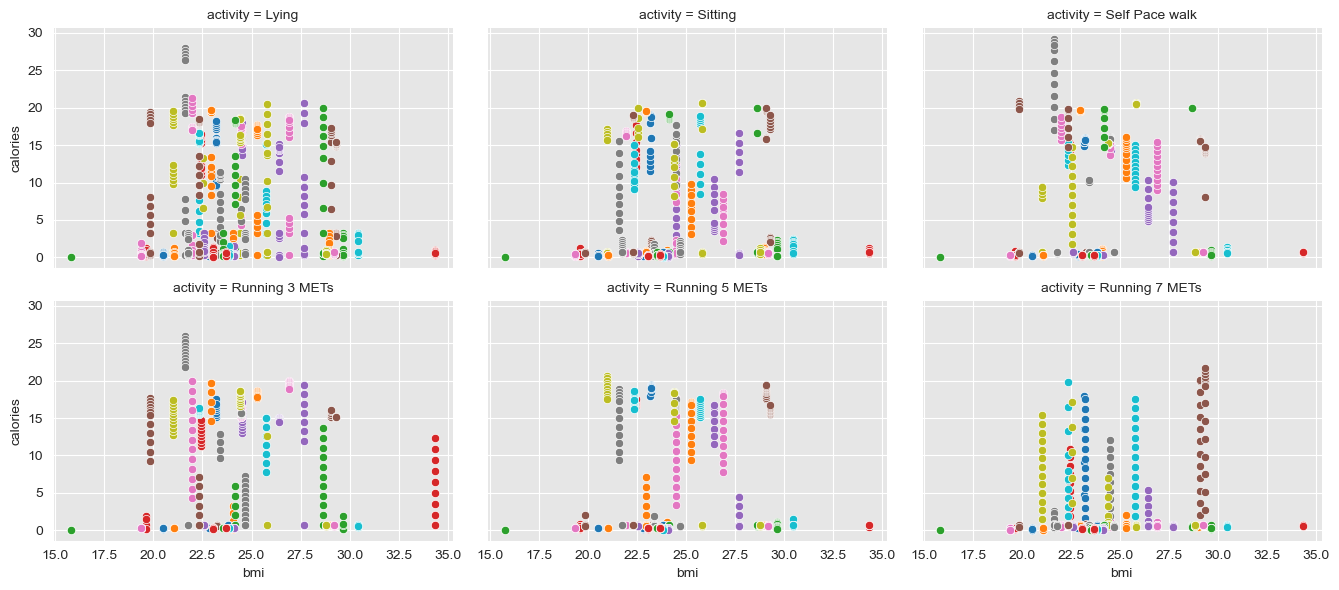

In [6]:
g = sns.FacetGrid(data = df_a,col='activity', col_wrap=3,height=3,aspect=1.5,hue = 'person',palette = 'tab10')
g.map(sns.scatterplot,'bmi','calories' )
plt.tight_layout()

The provided image shows a FacetGrid of scatter plots, visualizing the relationship between bmi (Body Mass Index) and calories for different activity levels, with each point representing a different person.

Overall Observations:

There seems to be a general trend of increasing calories with increasing bmi across most activities.
The scatter plots are quite dense, indicating a large number of data points for each activity.
There's significant overlap between the data points, suggesting that bmi and calories might not be strongly correlated for some activities.

Activity-Specific Insights:

Lying and Sitting:
These activities show a wider range of bmi values compared to other activities, with relatively low calories burned.

Self-Pace Walk: 
This activity shows a moderate range of bmi values and a moderate increase in calories with increasing bmi.
Running 3 METS, Running 5 METS, and Running 7 METS: These activities show a narrower range of bmi values, likely due to the physical exertion involved. The calories burned increase significantly with bmi in these activities, indicating a stronger correlation.

For the Apple Watch data it appears each person tend to show consistent calories burned across all activities as we can see the snowman like stacking of the dots.


C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


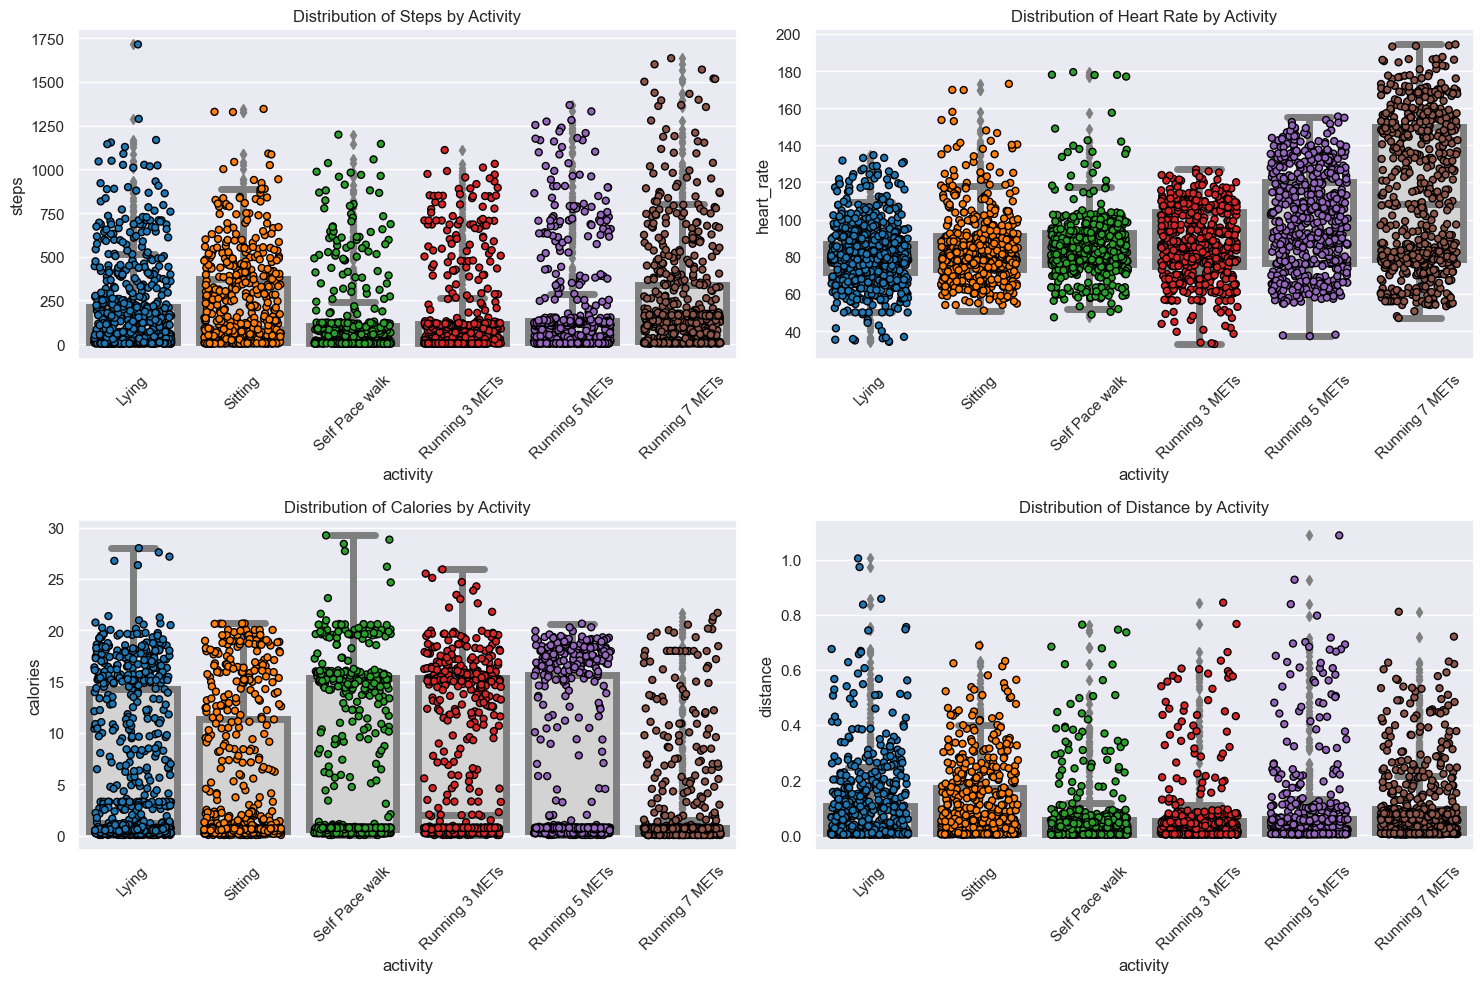

In [7]:
sns.set(font_scale=1)
params = dict(data=df_a,
              x='activity',            
              order=['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs'])
# List of Variables to Compare Distributions
distribution_vars = ['steps', 'heart_rate',
                     'calories','distance',
                     'entropy_heart','calories_bmi',
                     'corr_heart_steps','norm_heart', 
                     'intensity_karvonen','sd_norm_heart', ] 
grid_strip_box(2,2,(15,10),var_list=distribution_vars[0:4],**params)

1. Steps:

Lying and Sleeping: These activities have the lowest step counts, as expected.
Self-paced walk and Running: These activities show a significant increase in step counts compared to lying and sleeping, with running generally leading to higher step counts.
Running at different MET levels: As the MET level increases, the step count also tends to increase.

2. Heart Rate:

Lying and Sleeping: These activities have the lowest heart rate.
Self-paced walk and Running: Both activities show a significant increase in heart rate compared to lying and sleeping, with running leading to a higher heart rate.
Running at different MET levels: The heart rate generally increases with the MET level of running.

3. Calories:

Lying and Sleeping: These activities have the lowest calorie burn.
Self-paced walk and Running: Both activities show a significant increase in calorie burn compared to lying and sleeping, with running leading to a higher calorie burn.
Running at different MET levels: The calorie burn generally increases with the MET level of running.

4. Distance:

Lying and Sleeping: These activities have the lowest distance covered.
Self-paced walk and Running: Both activities show a significant increase in distance covered compared to lying and sleeping, with running leading to a higher distance covered.
Running at different MET levels: The distance covered generally increases with the MET level of running.


C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


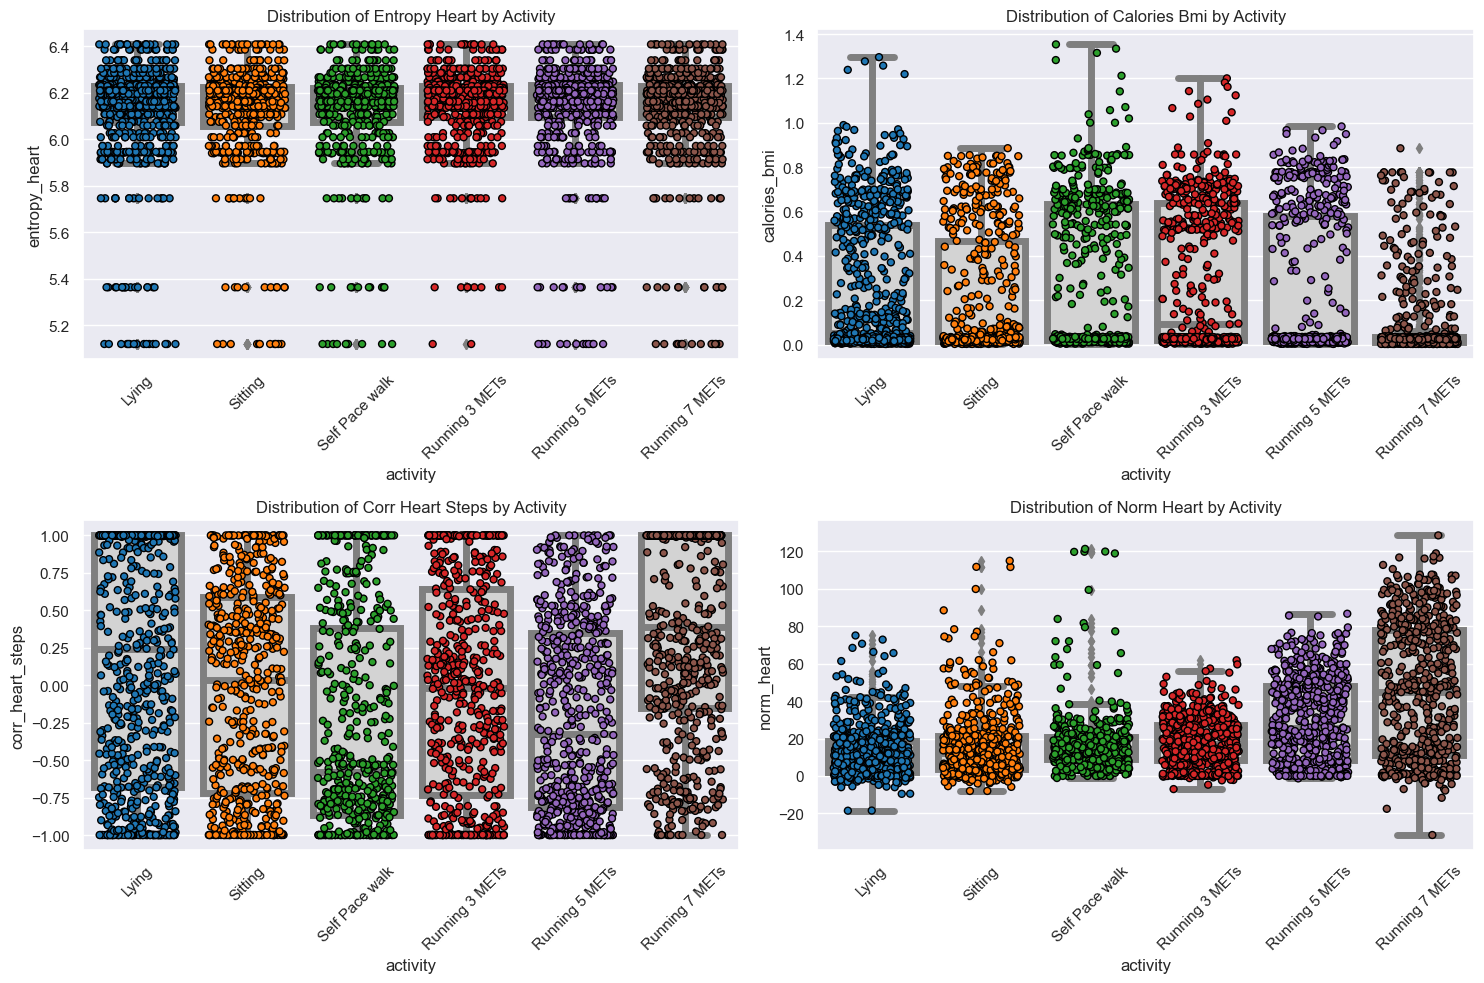

In [8]:
# List of Variables to Compare Distributions
grid_strip_box(2,2,(15,10),var_list=distribution_vars[4:9],**params)

1. Entropy Heart:

Lying and Sleeping: These activities have the lowest entropy heart values.
Self-paced walk and Running: Both activities show an increase in entropy heart compared to lying and sleeping, with running leading to a higher entropy heart.
Running at different MET levels: The entropy heart generally increases with the MET level of running, indicating a more complex heart rate pattern during higher intensity activities.
    
2. Calories Burned:

Lying and Sleeping: These activities have the lowest calorie burn.
Self-paced walk and Running: Both activities show a significant increase in calorie burn compared to lying and sleeping, with running leading to a higher calorie burn.
Running at different MET levels: The calorie burn generally increases with the MET level of running.
    
3. Correlation between Heart Rate and Steps:

Lying and Sleeping: The correlation between heart rate and steps is low or negative, as expected.
Self-paced walk and Running: Both activities show a positive correlation between heart rate and steps, with a stronger correlation for running.
Running at different MET levels: The correlation generally increases with the MET level of running.
    
4. Normalized Heart Rate:

Lying and Sleeping: These activities have the lowest normalized heart rate.
    
Self-paced walk and Running: Both activities show an increase in normalized heart rate compared to lying and sleeping, with running leading to a higher normalized heart rate.
Running at different MET levels: The normalized heart rate generally increases with the MET level of running.
    
Overall, these graphs provide insights into how different activities impact various heart rate metrics and energy expenditure. The data suggests that running, especially at higher intensities, leads to significant increases in heart rate variability and energy expenditure.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


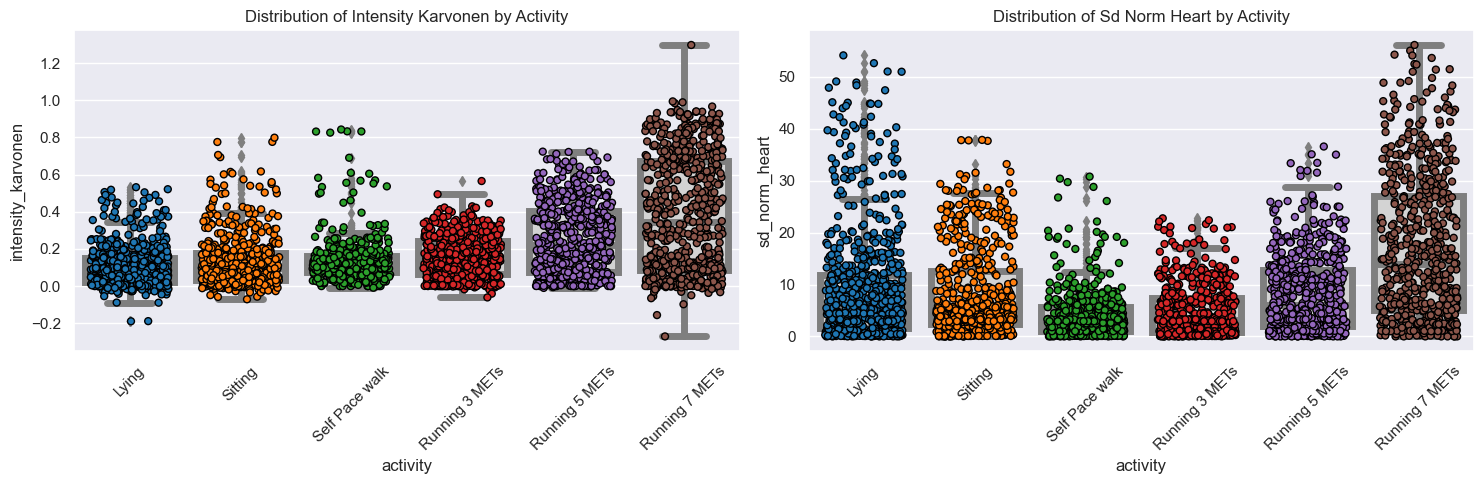

In [9]:
grid_strip_box(1,2,(15,5),var_list=distribution_vars[8:],**params)

Lying and Sitting: These activities have the lowest intensity Karvonen values, indicating minimal physical exertion.
    
Self-Paced Walk: This activity shows a slight increase in intensity Karvonen compared to lying and sitting, suggesting moderate physical activity.
    
Running: As the MET level of running increases, the intensity Karvonen values also increase significantly, indicating higher intensity levels.
Distribution of Sd_Norm_Heart by Activity

This graph illustrates the distribution of standard deviation of normalized heart rate across different activities. Here are some key insights:

Lying and Sitting: These activities exhibit the lowest standard deviation of normalized heart rate, suggesting a relatively stable heart rate pattern during rest.
    
Self-Paced Walk: This activity shows a moderate increase in standard deviation compared to lying and sitting, indicating some variation in heart rate during walking.
    
Running: As the MET level of running increases, the standard deviation of normalized heart rate also increases significantly. This suggests that running, especially at higher intensities, leads to greater variability in heart rate patterns.

For Apple Watch Data it looks like heart rate, sd norm hear, intensity karvonen all show separation by activity. Next I will look at some histograms for norm heart and the calories/bmi feature.

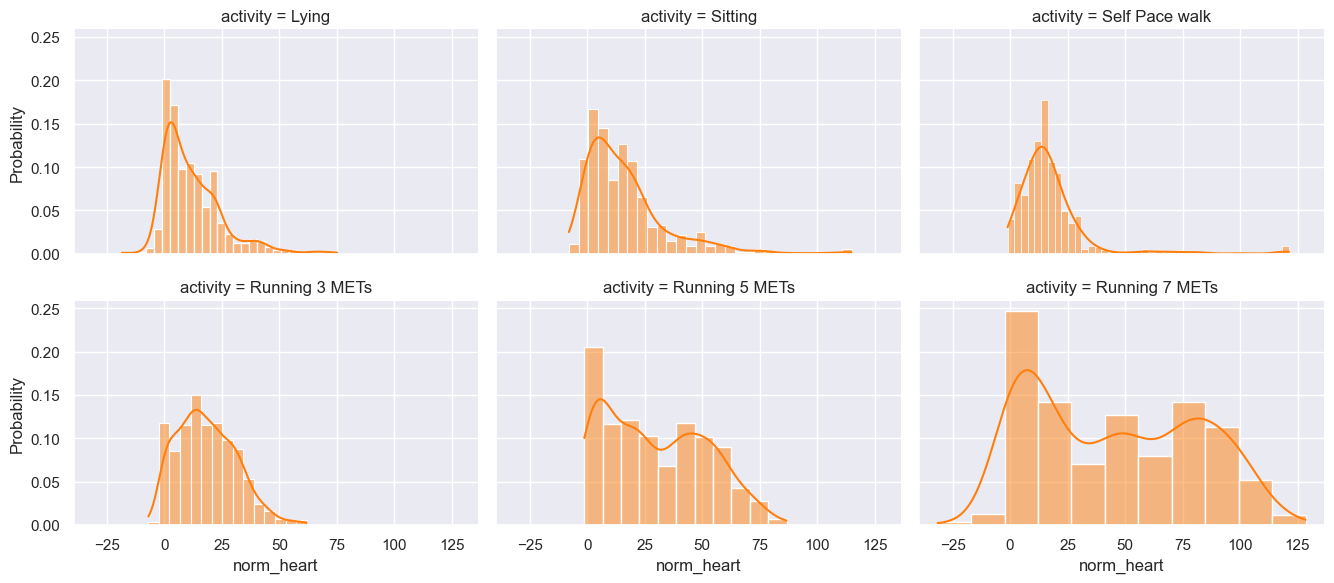

In [10]:
g = sns.FacetGrid(data = df_a,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'norm_heart', kde =True , color = '#ff7f0e', stat='probability')
plt.tight_layout()

Lying and Sitting: The distributions for lying and sitting are relatively narrow and centered around low norm_heart values, indicating minimal physical exertion and a stable heart rate.
Self-Paced Walk: The distribution for self-paced walking is slightly wider and shifted towards higher norm_heart values compared to lying and sitting, suggesting a moderate increase in heart rate during this activity.
    
Running: As the MET level of running increases, the distribution of norm_heart values becomes wider and shifts further towards higher values. This reflects the increasing intensity of the activity and the corresponding increase in heart rate.
Overlapping Distributions:

There is some overlap between the distributions for different activities, particularly at lower norm_heart values. This suggests that heart rate alone may not be sufficient to accurately distinguish between certain activities, especially at lower intensities.
Potential for Activity Classification:

The distinct distribution patterns for different activities suggest that machine learning models could potentially be trained to classify activities based on heart rate data. However, the overlap between distributions highlights the need for additional features or context to improve classification accuracy.

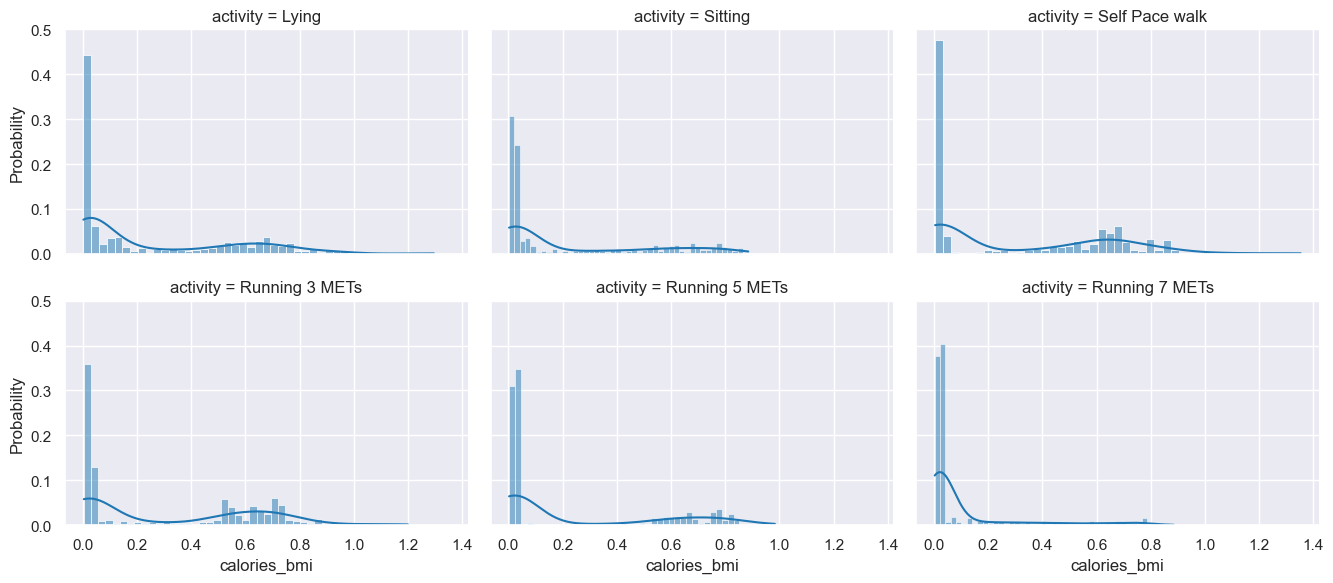

In [11]:
g = sns.FacetGrid(data = df_a,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'calories_bmi', kde =True , color = '#1f77b4', stat='probability',bins=45)
plt.tight_layout()

Lying and Sitting: The distributions for lying and sitting are concentrated around low calories_bmi values, indicating minimal energy expenditure during these activities.
    
Self-Paced Walk: The distribution for self-paced walking is shifted towards higher calories_bmi values compared to lying and sitting, suggesting a moderate increase in energy expenditure during this activity.
    
Running: As the MET level of running increases, the distribution of calories_bmi values shifts further towards higher values. This reflects the increasing intensity of the activity and the corresponding increase in energy expenditure.
Overlapping Distributions:

There is some overlap between the distributions for different activities, particularly at lower calories_bmi values. This suggests that calories_bmi alone may not be sufficient to accurately distinguish between certain activities, especially at lower intensities.
Potential for Activity Classification:

The distinct distribution patterns for different activities suggest that machine learning models could potentially be trained to classify activities based on calories_bmi data. However, the overlap between distributions highlights the need for additional features or context to improve classification accuracy.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\3629293236.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_a.corr(),annot=True,fmt='.2f')


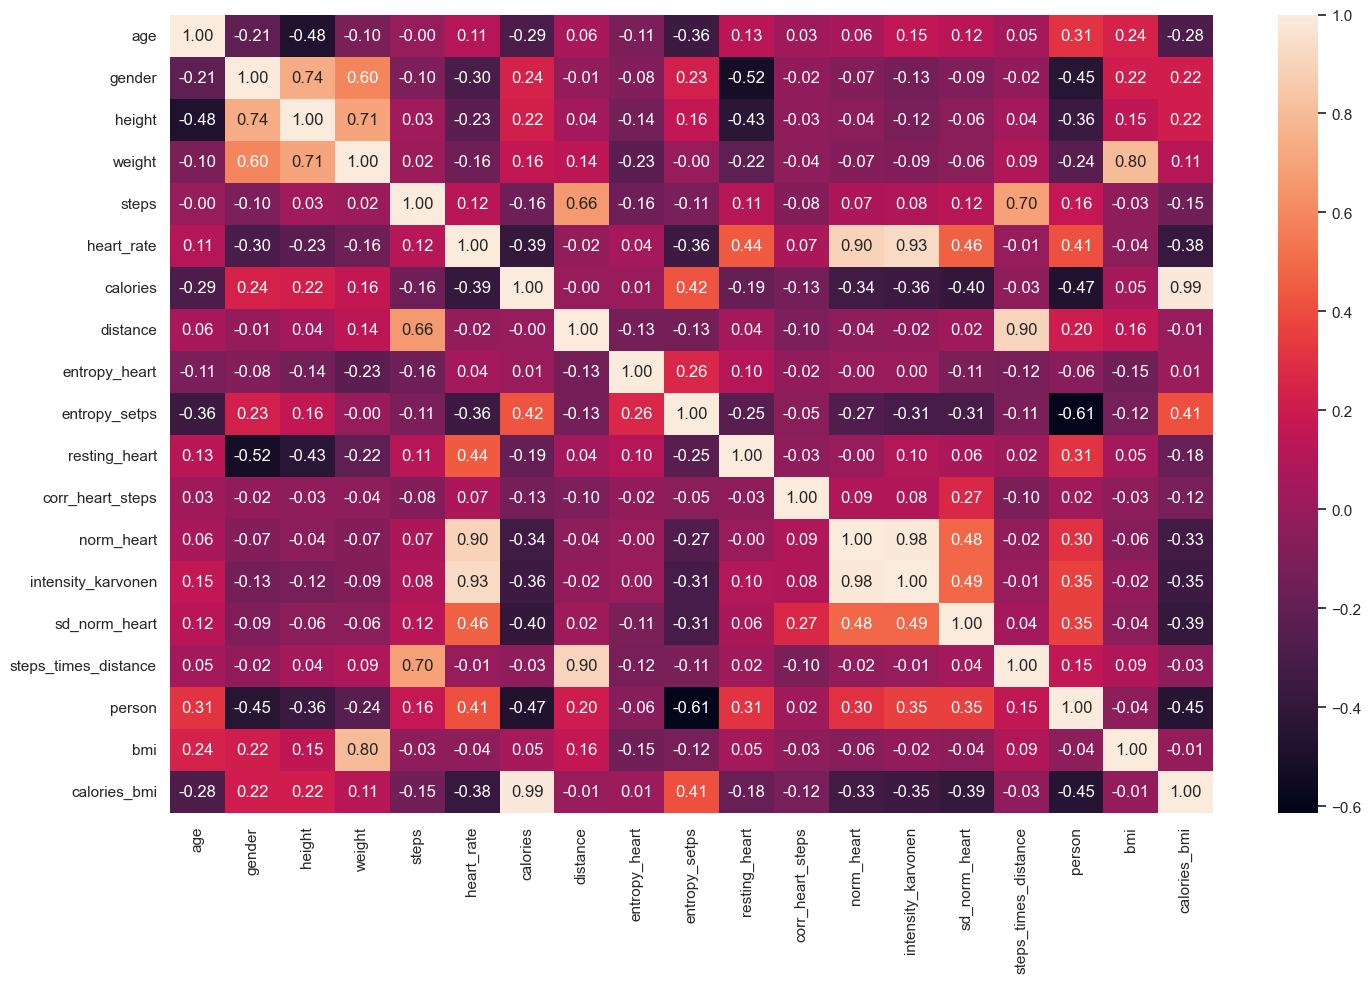

In [12]:
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
sns.heatmap(df_a.corr(),annot=True,fmt='.2f')
plt.tight_layout()

Strong Positive Correlations:

Height and Weight: These variables have a strong positive correlation, indicating that taller individuals tend to weigh more.
    
Heart Rate and Calories: A strong positive correlation exists between heart rate and calories burned, suggesting that higher heart rates are associated with increased energy expenditure.
    
Distance and Steps: These variables are highly correlated, as expected, as distance covered is directly related to the number of steps taken.
    
Norm Heart and Intensity Karvonen: A strong positive correlation exists between normalized heart rate and intensity Karvonen, indicating that higher intensity activities are associated with higher heart rates.


Strong Negative Correlations:

Age and Resting Heart Rate: There's a moderate negative correlation between age and resting heart rate, suggesting that resting heart rate may decrease with age.
Other Observations:

Gender and Height/Weight: Gender shows a moderate correlation with height and weight, indicating that males tend to be taller and heavier than females.

Entropy Heart and Entropy Steps: These variables have a moderate positive correlation, suggesting that increased heart rate variability is associated with increased step variability.

Person and BMI: There's a moderate negative correlation between person and BMI, indicating that certain individuals may have lower BMIs compared to others.
Overall, the heatmap provides a comprehensive overview of the relationships between different variables in the dataset. It highlights important correlations that can be further explored in statistical analysis and machine learning models.

Steps and Distance show a somewhat strong correlation. However, one would expect it to be stronger.

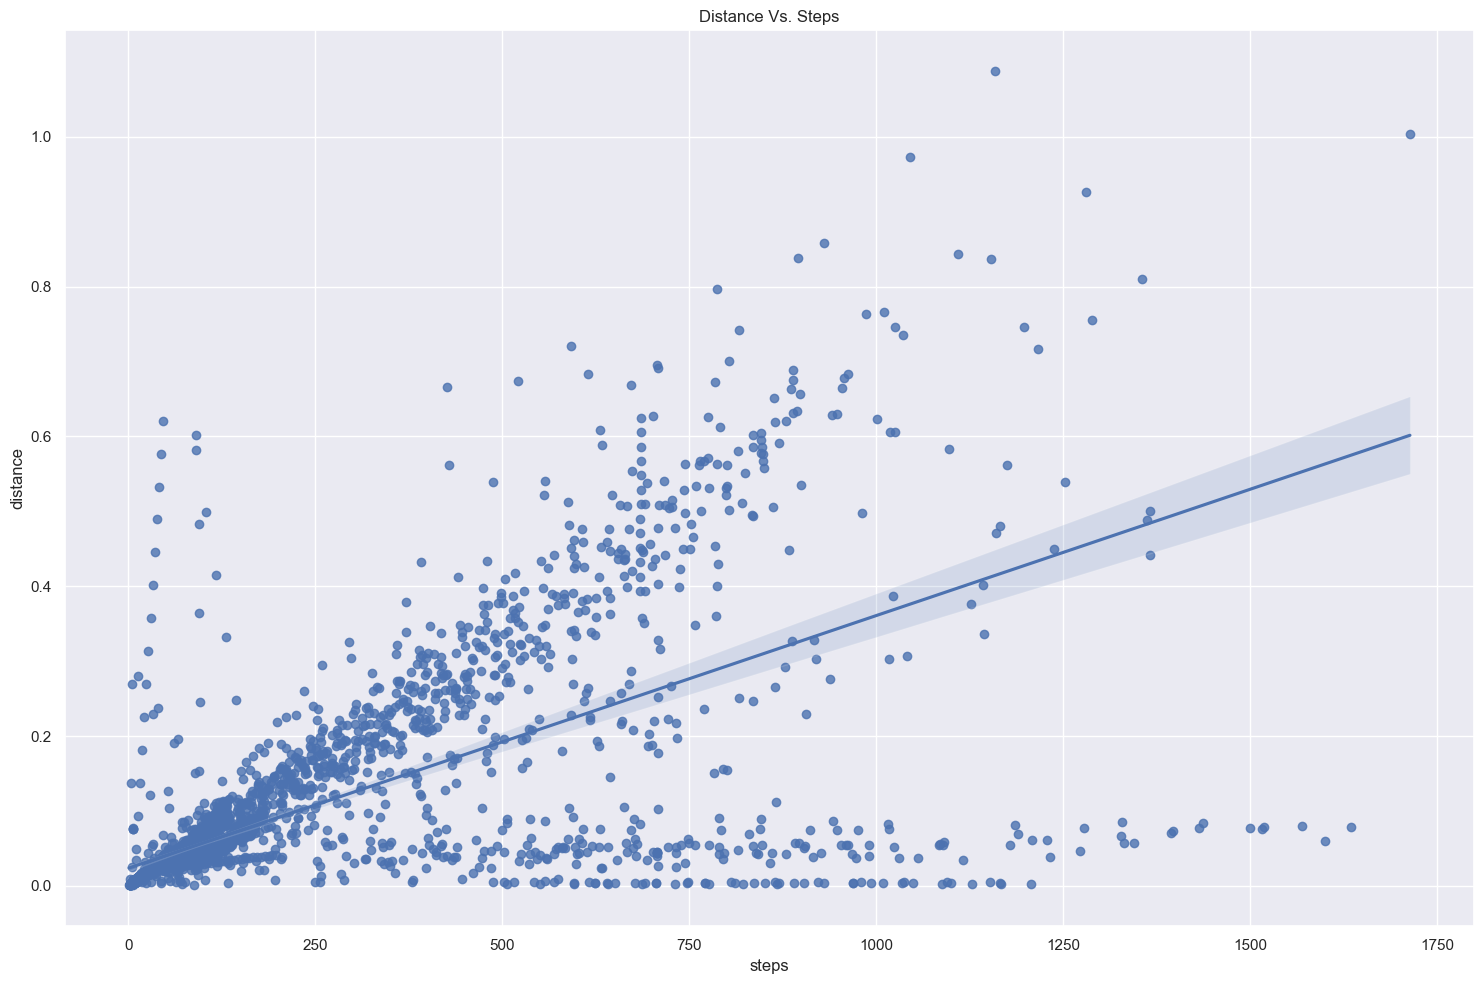

In [13]:

plt.figure(figsize=(15,10))
sns.regplot(data = df_a, x='steps', y='distance')
plt.title('Distance Vs. Steps')
plt.tight_layout()

1. Positive Correlation:
There is a clear positive correlation between distance and steps. This means that as the number of steps increases, the distance covered also increases.

2. Linear Trend:
The relationship appears to be roughly linear, with a slight upward curve. This suggests that the increase in distance is proportional to the increase in steps, with some diminishing returns at higher step counts.

3. Scatter:
The data points are scattered around the trend line, indicating some variability in the relationship. This could be due to factors like walking speed, terrain, or individual differences in stride length.

4. Outliers:
There are a few outliers in the data, particularly at higher step counts. These could be due to activities like running or cycling, which may lead to larger distances covered per step.

The Regplot shows there is a strong linear relationship between distance and steps, however the regression line is weighted down by high leverage noise in the data.


 <font size="5"> Training and Validation Apple Watch</font> 

In [14]:
# Break into Test Train Split
# predictor_list = ['calories','distance','norm_heart', 'intensity_karvonen','sd_norm_heart','hear_rate']
predictor_list = [col for col in df.columns if col not in ['activity','age', 'gender', 'height', 'weight','person','bmi','device','resting_heart']]
X = df_a[predictor_list]
y = df_a['activity']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , random_state = 42 , stratify=y)

1. Identifying Predictors and Target Variable:

Predictor List:
The code first identifies the columns that will be used as predictors (independent variables) to predict the target variable (dependent variable). These predictors are extracted from the df DataFrame, excluding columns like activity, age, gender, etc., which are likely not relevant for prediction or are already part of the target variable.

X and y:
The X variable is assigned to the DataFrame containing the predictor columns from the df_a DataFrame.
The y variable is assigned to the target variable column, which is 'activity' in this case.

2. Splitting the Data:

train_test_split:

The train_test_split function from the sklearn.model_selection module is used to divide the data into training and testing sets.
X and y: The X and y variables, containing the predictors and target variable, respectively, are passed to the function.

test_size=0.3: This parameter specifies that 30% of the data will be allocated to the testing set, while the remaining 70% will be used for training.

random_state=42: This parameter sets a seed for the random number generator, ensuring reproducibility of the split.

stratify=y: This parameter ensures that the proportion of different classes (activity types) in the target variable y is maintained in both the training and testing sets. This is crucial for balanced datasets, where some classes might be underrepresented.

 <font size="5"> PCA Apple Watch</font> 

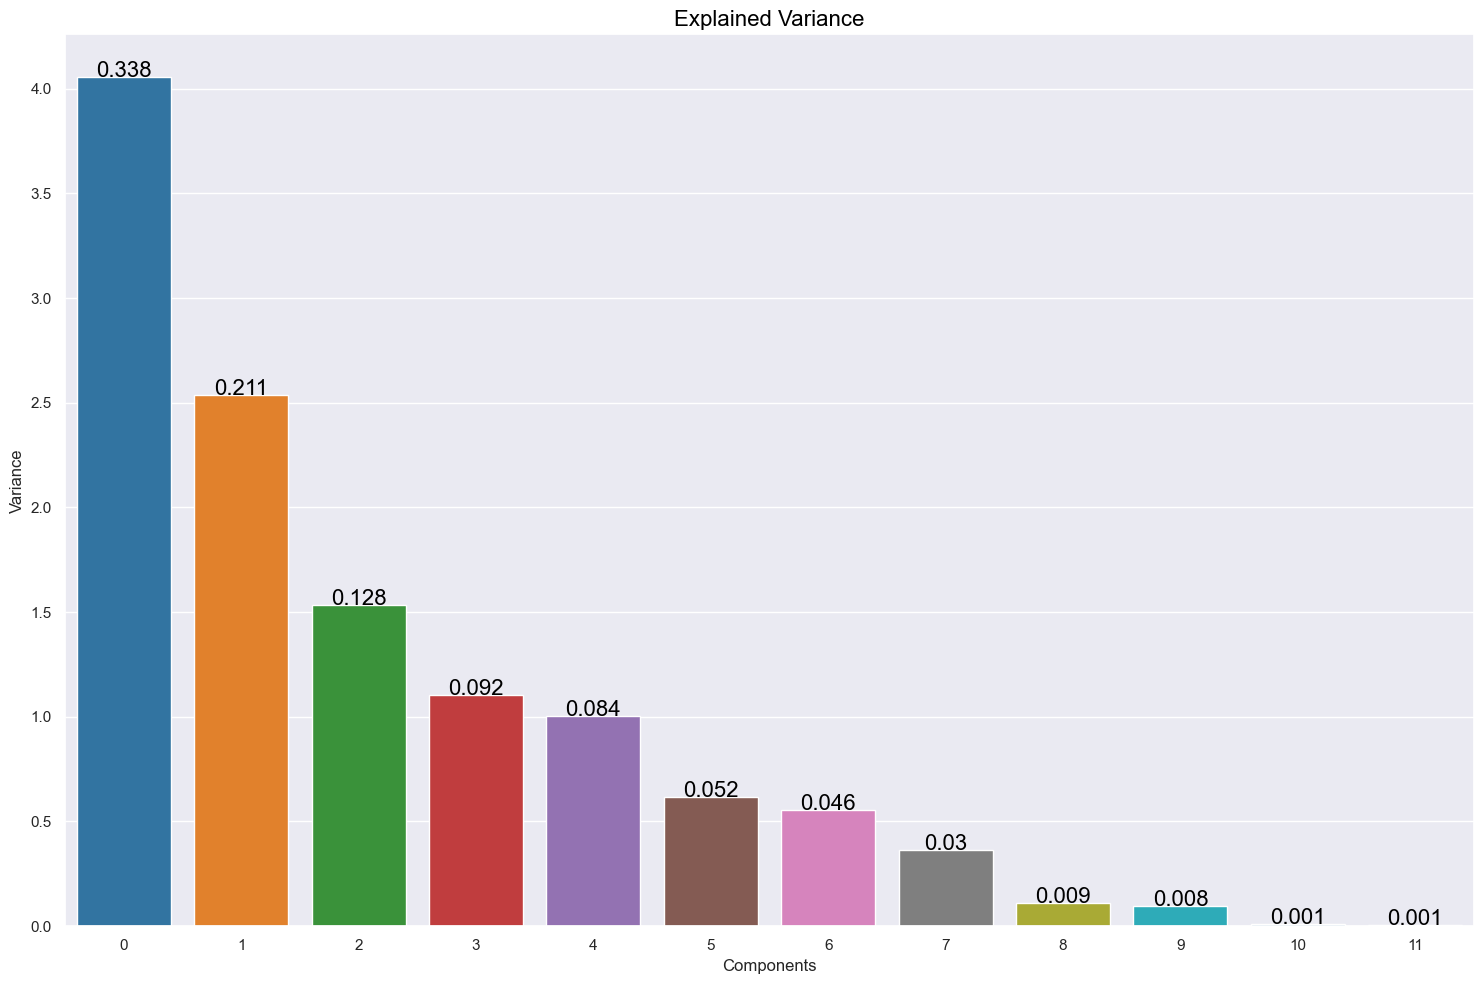

In [15]:
X_train_scaled = scale_data(X_train)
plt.figure(figsize = (15,10))
pca = PCA()
pca.fit(scale_data(X_train_scaled)) 
components = range(pca.n_components_)
plot_comp_df = pd.DataFrame({'Components':components, 'Variance':pca.explained_variance_})
bp = sns.barplot(x = 'Components',y = 'Variance',data = plot_comp_df , palette = 'tab10')
variance_ratios = [round(float(ratio),3) for ratio in pca.explained_variance_ratio_]
# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'normal',
#         'size': 16,
#         }

font = {'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


for component,variance,ratio in zip(components , pca.explained_variance_ ,variance_ratios):
    bp.text(x=component,y=variance,s=ratio,ha="center",fontdict = font)

plt.title('Explained Variance',fontdict = font)
plt.tight_layout()


Dominant Components:

The first two PCs capture a significant portion of the variance in the data. The first PC explains approximately 33.8% of the variance, while the second PC accounts for 21.1%. This indicates that these two components are the most informative and can potentially be used to represent the original data with minimal loss of information.

Diminishing Returns:

As we move to higher-order PCs, the explained variance progressively decreases. For instance, the third PC explains only 12.8% of the variance, and the subsequent PCs explain even smaller portions. This suggests that the contribution of higher-order PCs to the overall variance is diminishing.

Elbow Point:
The plot seems to have an "elbow" around the 2nd or 3rd PC. This elbow point can be used as a guideline to determine the optimal number of PCs to retain. In this case, keeping the first two or three PCs might be sufficient to capture the majority of the variance.

In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([0.3379037 , 0.54920335, 0.67697251, 0.7690594 , 0.85277783,
       0.9043518 , 0.95059615, 0.98099062, 0.99022272, 0.99837684,
       0.99934753, 1.        ])

C:\Users\delmo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


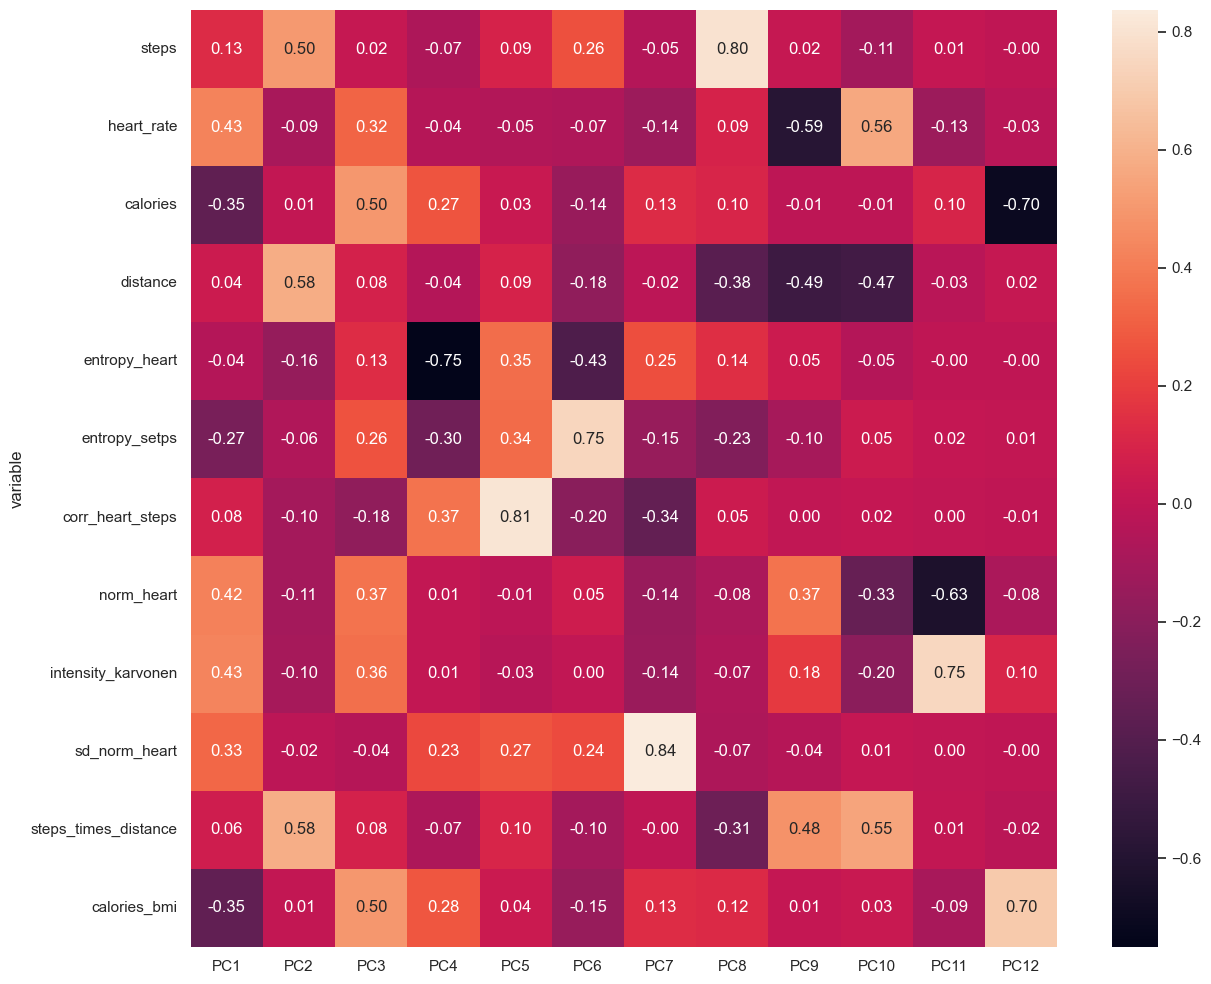

In [17]:
sns.set(font_scale=1)
plt.figure(figsize = (13,10))
loadings = pca.components_
n_comp = pca.n_features_
pc_list = ["PC"+str(i) for i in range(1,n_comp+1)]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_train.columns.values
loadings_df = loadings_df.set_index('variable')
sns.heatmap(loadings_df ,annot=True,fmt='.2f')
plt.tight_layout()

PC1:
The first PC (PC1) has strong positive correlations with variables like steps, distance, and steps_times_distance. This suggests that PC1 captures variations related to physical activity levels.

PC2:
PC2 shows strong positive correlations with variables like heart_rate and intensity_karvonen. This indicates that PC2 captures variations related to heart rate and exercise intensity.

PC3:
PC3 has a strong positive correlation with calories and a negative correlation with heart_rate. This suggests that PC3 captures variations related to energy expenditure and heart rate regulation.

PC4:
PC4 has a strong positive correlation with entropy_heart and corr_heart_steps. This indicates that PC4 captures variations related to the complexity and synchronization of heart rate patterns.
Higher-Order PCs:

As we move to higher-order PCs (PC5 and beyond), the correlations with the original variables become weaker and more dispersed. This suggests that these PCs capture more subtle and specific variations in the data, which are less easily interpretable.

PCA shows that 6 PCs cover 95% of the variance in the predictor space. 
The PCA correlation plot shows a few mild correlations between the norm_heart predictor, intensity karvonen and the first PC.

 <font size="5"> K-Means Clustering Apple Watch</font> 

In [18]:
k_s = list(range(2,len(y_train.unique() ) + 3))
inertias = [calculate_inertia(k,X_train_scaled) for k in k_s]


C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environm

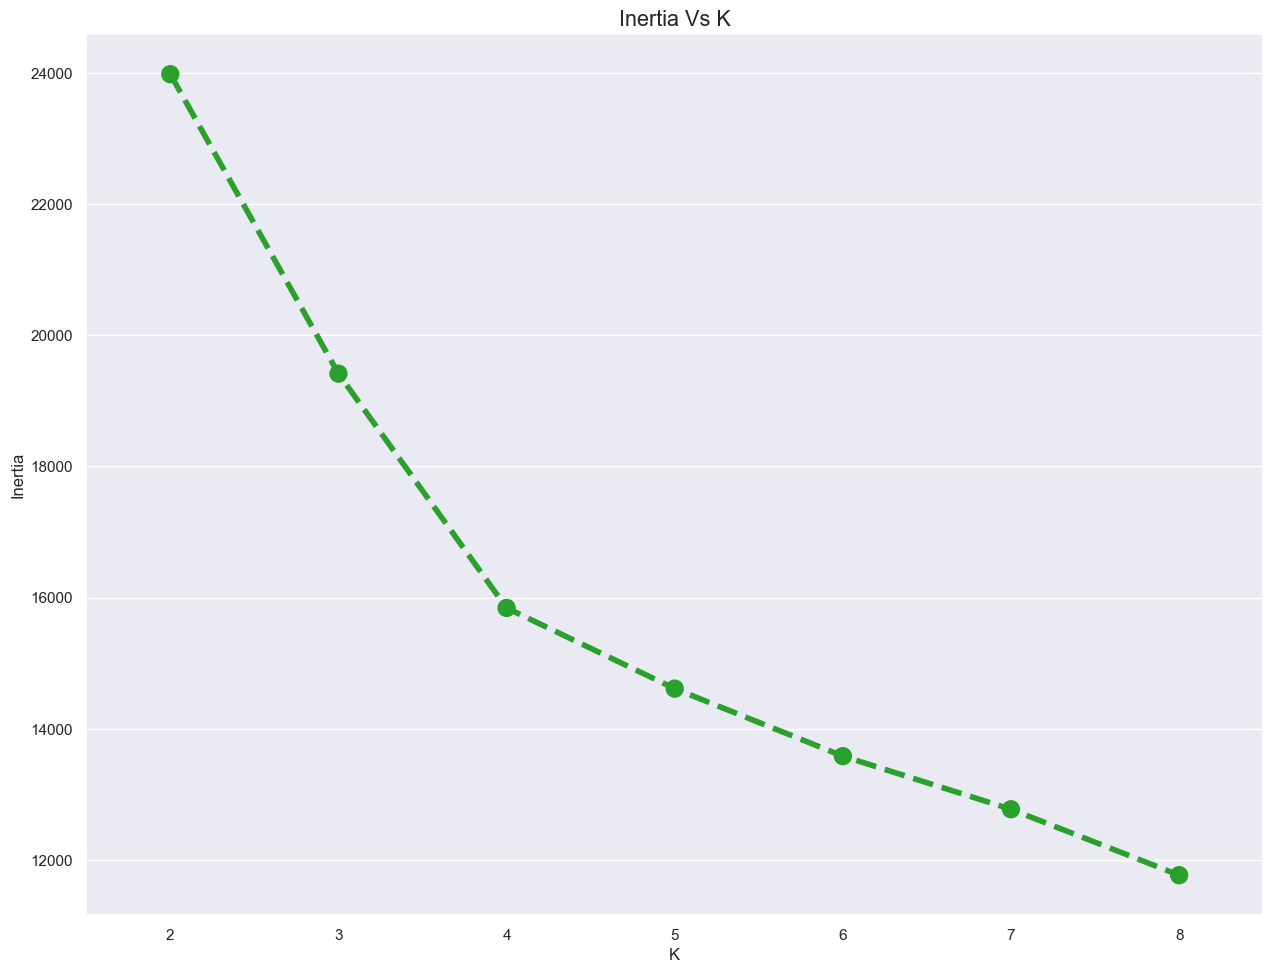

In [19]:
plt.figure(figsize = (13,10))
sns.pointplot(x=k_s,y=inertias , linestyles ='--',markers = 'o',scale=1.5, color='#2ca02c')
sns.set(font_scale=1.3)
plt.title('Inertia Vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout()

Inertia: The y-axis represents inertia, which is a measure of the within-cluster sum of squares. Lower inertia indicates better clustering, as it means data points are closer to their respective cluster centroids.

K: The x-axis represents the number of clusters (K). As K increases, the inertia generally decreases because each data point is closer to its assigned cluster centroid.
Elbow Point:

The elbow point is the point on the curve where the rate of decrease in inertia starts to slow down significantly. This is often considered the optimal value for K. In this plot, the elbow point appears to be around K=2 or K=3.
Insights:

Optimal Number of Clusters: Based on the elbow curve, it seems that choosing 2 or 3 clusters might be a good starting point. However, the optimal number of clusters can also depend on the specific data and the desired outcome.

Trade-off: Increasing the number of clusters (K) can lead to lower inertia but might also overfit the data. It's important to find a balance between reducing inertia and avoiding overfitting.

The inertia elblow plot suggests that 4 would be an ideal number for k on the predictor space.

In [20]:
model_kmeans = KMeans(n_clusters = 4 , random_state=42)
model_kmeans.fit_predict(X_train_scaled)
clusters = pd.Series( model_kmeans.fit_predict(X_train_scaled)).rename('clusters',inplace= True)

C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environm

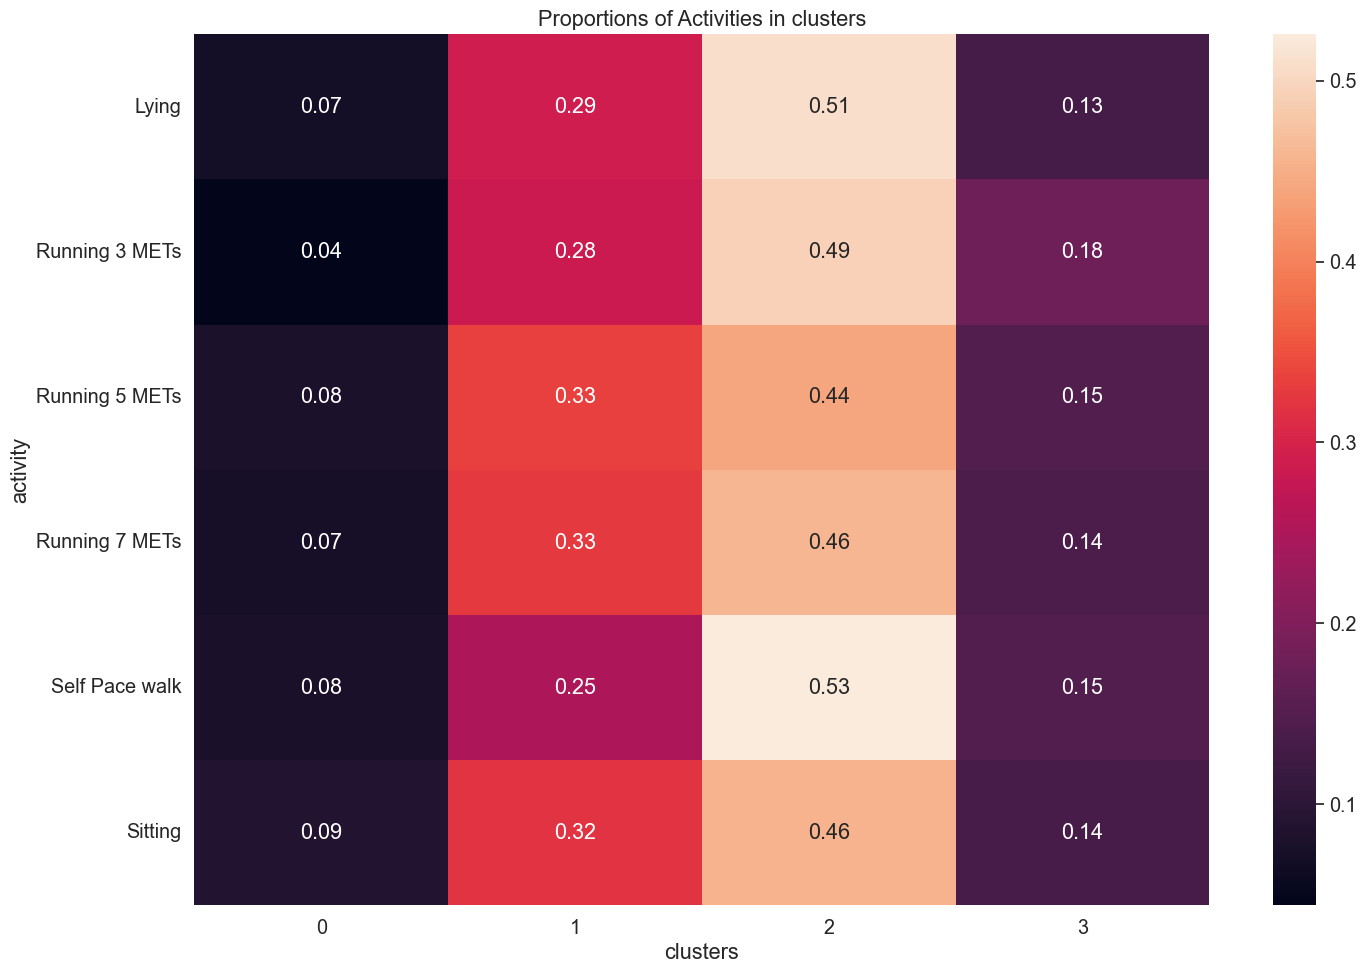

In [21]:
plt.figure(figsize = (15,10))
cross_tab = pd.crosstab(y_train,clusters,normalize=False)
cross_tab.values
row_sums = cross_tab.values.sum(axis=1)
proportions = cross_tab / row_sums.reshape((6,1))
sns.heatmap(proportions,annot=True,fmt='.2f')
plt.title('Proportions of Activities in clusters')
plt.tight_layout()

Cluster 0:
Cluster 0 seems to be dominated by "Lying" and "Sitting" activities. This suggests that this cluster likely represents periods of inactivity or low-intensity activities.

Cluster 1:
Cluster 1 has higher proportions of "Running 3 METS" and "Running 5 METS." This indicates that this cluster likely represents periods of moderate-intensity running activities.

Cluster 2:
Cluster 2 has higher proportions of "Self-Pace Walk" and "Sitting." This suggests that this cluster likely represents periods of low-intensity walking and sedentary activities.

Cluster 3:
Cluster 3 has the highest proportion of "Running 7 METS." This indicates that this cluster likely represents periods of high-intensity running activities.

There does not appear to be a strong relationship between the activities and the clusters from k means as the frequency of each level of activity does not favor any 1 particular cluster.

 <font size="5"> Random Forest Pipeline Apple Watch</font> 

In [22]:
parameters = {'clf__criterion':['entropy','gini'] , 'clf__max_depth':[80,100] , 'clf__n_estimators':[100,120],"clf__max_features":['sqrt', 'log2']}
rf_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,RandomForestClassifier())
grid_cv = rf_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

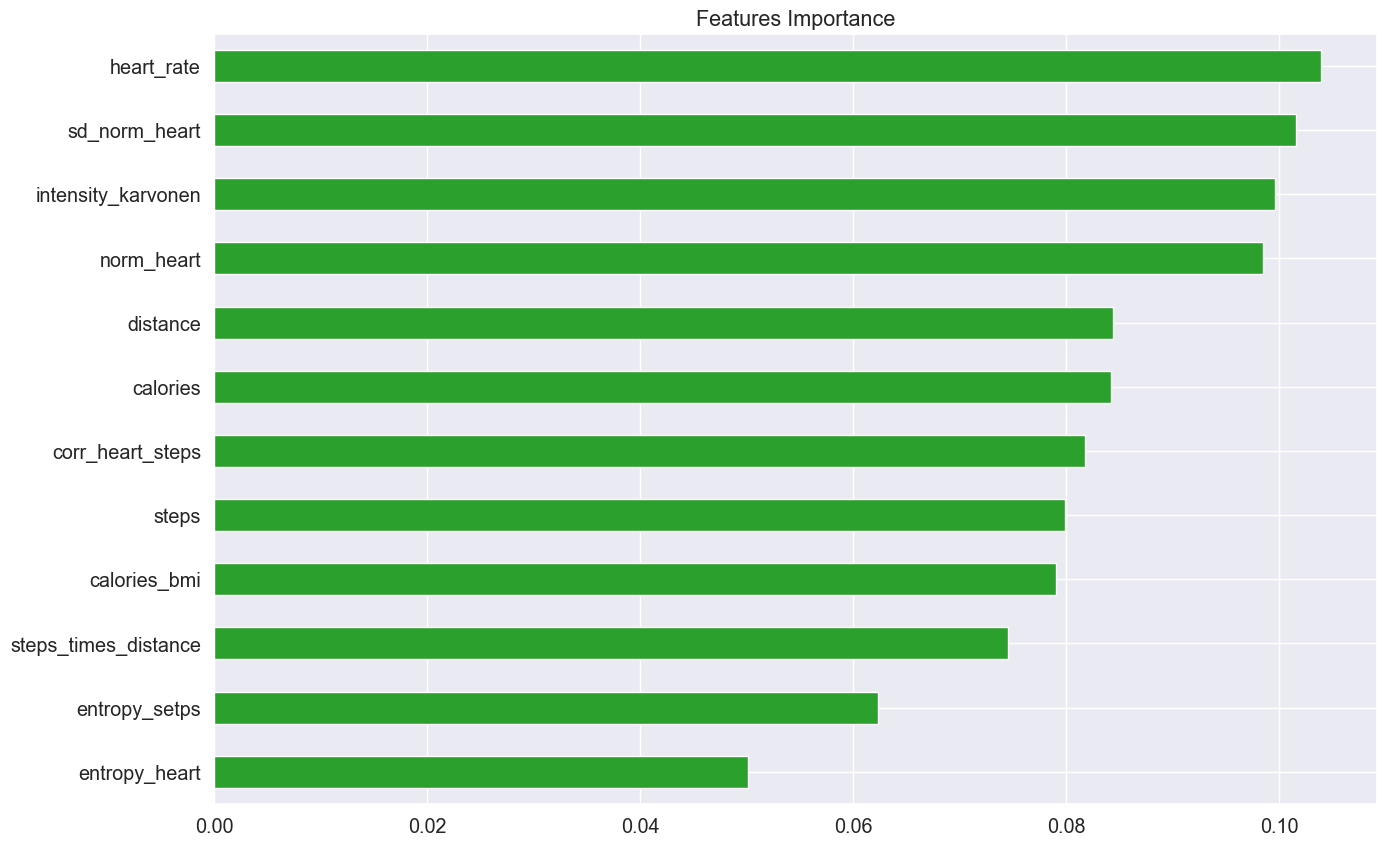

In [23]:
grid_cv.best_params_
rf_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
rf = RandomForestClassifier()
rf.set_params(**rf_params)
rf.fit(X_train,y_train)

importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

Top Features:

The features with the highest importance scores are heart_rate, sd_norm_heart, and intensity_karvonen. This suggests that these features are the most influential in determining the model's predictions.

Feature Ranking:
    
The features are ranked in descending order of importance. This allows us to identify the most important features and focus on them for further analysis or feature engineering.
Feature Importance Distribution:

The importance scores vary across features, with some features having significantly higher importance than others. This indicates that not all features contribute equally to the model's predictions.
Possible Implications

Feature Selection: The feature importance plot can be used to identify the most important features and select a subset of features for further analysis or model building. This can help reduce model complexity and improve computational efficiency.

Model Interpretation: The feature importance plot can help us understand how the model makes its predictions. By identifying the most important features, we can gain insights into the underlying relationships between the features and the target variable.

Feature Engineering: The feature importance plot can guide feature engineering efforts. By identifying the most important features, we can focus on creating new features that are more informative and relevant to the model.

In [24]:
rf_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.75      0.80      0.77       236
Running 3 METs       0.83      0.83      0.83       172
Running 5 METs       0.83      0.85      0.84       181
Running 7 METs       0.90      0.88      0.89       184
Self Pace walk       0.82      0.77      0.79       159
       Sitting       0.73      0.70      0.72       165

      accuracy                           0.81      1097
     macro avg       0.81      0.80      0.81      1097
  weighted avg       0.81      0.81      0.81      1097



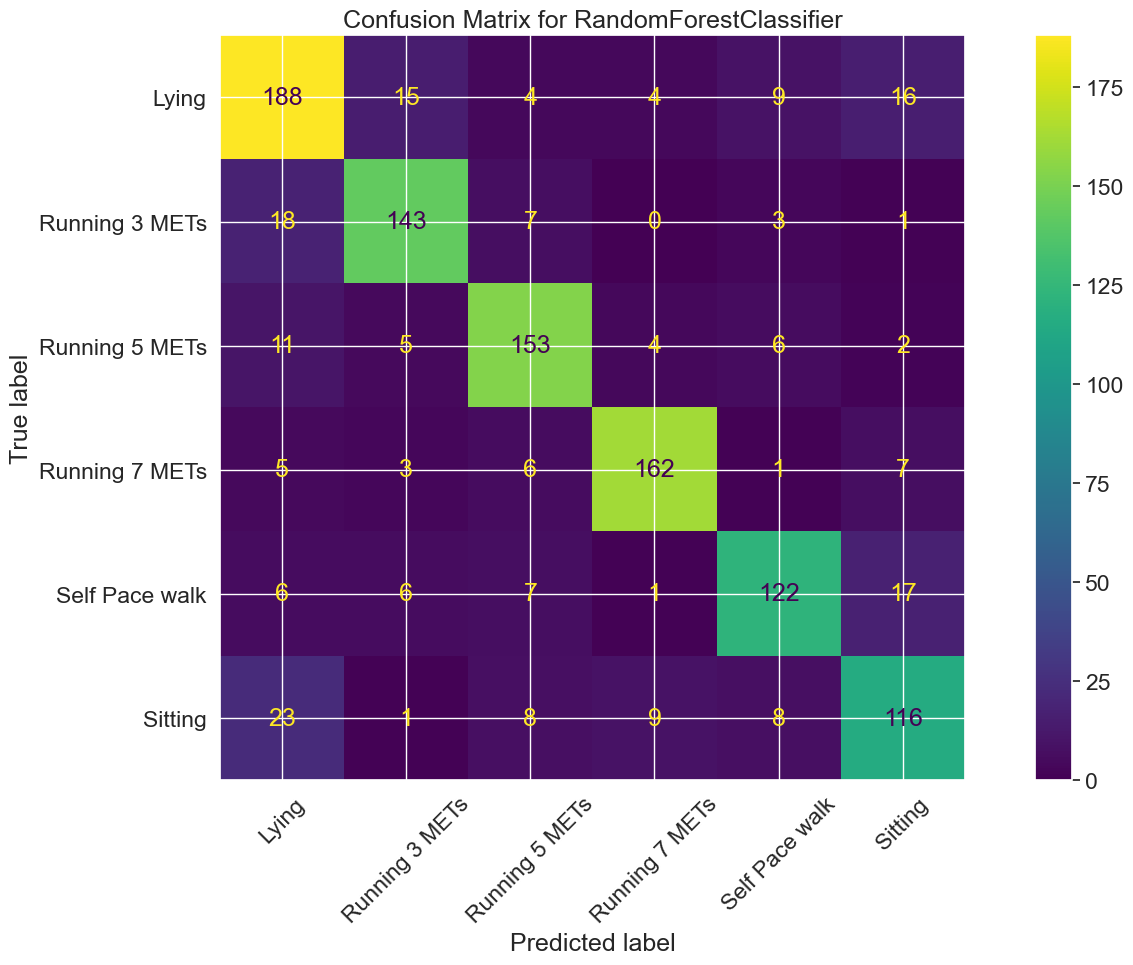

In [25]:
rf_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

Diagonal Elements: The diagonal elements represent the number of instances that were correctly classified. For example, the value 188 in the top-left cell indicates that 188 instances of the "Lying" class were correctly classified as "Lying."

Off-Diagonal Elements: The off-diagonal elements represent the number of instances that were misclassified. For example, the value 16 in the first row, second column indicates that 16 instances of the "Lying" class were incorrectly classified as "Running 3 METS."

Overall Performance: The overall performance of the model can be assessed by looking at the diagonal elements. A higher proportion of correct classifications on the diagonal indicates better performance.
Possible Implications


Class-Wise Performance: The confusion matrix can be used to evaluate the performance of the model on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis: The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

Model Improvement: The confusion matrix can be used to guide model improvement efforts. By identifying the classes with the highest misclassification rates, we can focus on improving the model's performance on those classes. This might involve collecting more training data, using different features, or trying different model architectures.

The Random Forest had an 82 percent accuracy and had 0.90 precision and 0.88 recall on the Running 7 Mets category.
Additionally, for Apple Watch data the variable importance favored the variables related to heart rate. It will be interesting to see if this holds for Fitbit data as well.

 <font size="5"> KNN Pipeline Apple Watch</font> 

In [26]:
parameters = {'clf__n_neighbors':list(range(3,15,1)),'clf__metric':['euclidean']}
steps = [('scale',StandardScaler()),('KNN',KNeighborsClassifier())]

knn_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,KNeighborsClassifier())
knn_model.create_pipeline()
grid_cv = knn_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [27]:
knn_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.52      0.66      0.58       236
Running 3 METs       0.65      0.74      0.69       172
Running 5 METs       0.63      0.67      0.65       181
Running 7 METs       0.72      0.61      0.66       184
Self Pace walk       0.71      0.61      0.66       159
       Sitting       0.50      0.35      0.41       165

      accuracy                           0.61      1097
     macro avg       0.62      0.61      0.61      1097
  weighted avg       0.62      0.61      0.61      1097



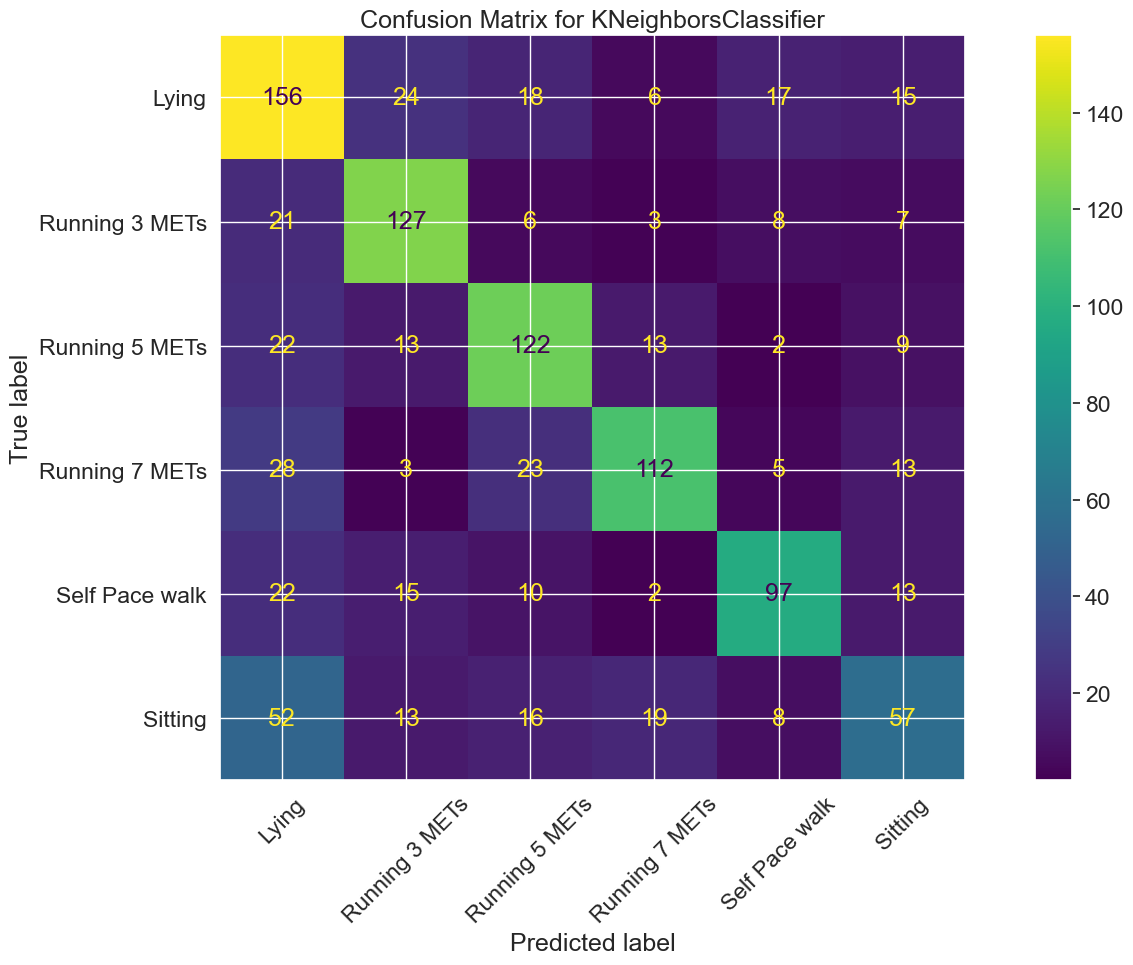

In [28]:
knn_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

Diagonal Elements: The diagonal elements represent the number of instances that were correctly classified. For example, the value 156 in the top-left cell indicates that 156 instances of the "Lying" class were correctly classified as "Lying."

Off-Diagonal Elements: The off-diagonal elements represent the number of instances that were misclassified. For example, the value 24 in the first row, second column indicates that 24 instances of the "Lying" class were incorrectly classified as "Running 3 METS."

Overall Performance: The overall performance of the model can be assessed by looking at the diagonal elements. A higher proportion of correct classifications on the diagonal indicates better performance.
Possible Implications

Class-Wise Performance: The confusion matrix can be used to evaluate the performance of the model on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis: The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

Model Improvement: The confusion matrix can be used to guide model improvement efforts. By identifying the classes with the highest misclassification rates, we can focus on improving the model's performance on those classes. This might involve collecting more training data, using different features, or trying different model architectures.
Additional Considerations

Data Quality: The quality of the training data can significantly impact the performance of the model. Noisy or biased data can lead to poor performance.

Model Complexity: The complexity of the model can also affect its performance. A more complex model might be able to capture more intricate patterns in the data, but it might also be more prone to overfitting.

Evaluation Metrics: In addition to the confusion matrix, other evaluation metrics like accuracy, precision, recall, and F1-score can be used to assess the performance of the model.

Knn shows a 61 percent accuracy which is much lower than the Random Forest.

 <font size="5"> NB Pipeline Apple Watch</font> 

In [29]:
parameters = {'clf__var_smoothing':[1e-9,1e-8,1e-7]}
steps = [('scale',StandardScaler())]
nb_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,GaussianNB())
nb_model.create_pipeline(steps = steps)
grid_cv = nb_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

In [30]:
nb_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.39      0.38      0.39       236
Running 3 METs       0.25      0.17      0.21       172
Running 5 METs       0.27      0.08      0.13       181
Running 7 METs       0.46      0.53      0.49       184
Self Pace walk       0.26      0.69      0.37       159
       Sitting       0.19      0.06      0.09       165

      accuracy                           0.32      1097
     macro avg       0.30      0.32      0.28      1097
  weighted avg       0.31      0.32      0.29      1097



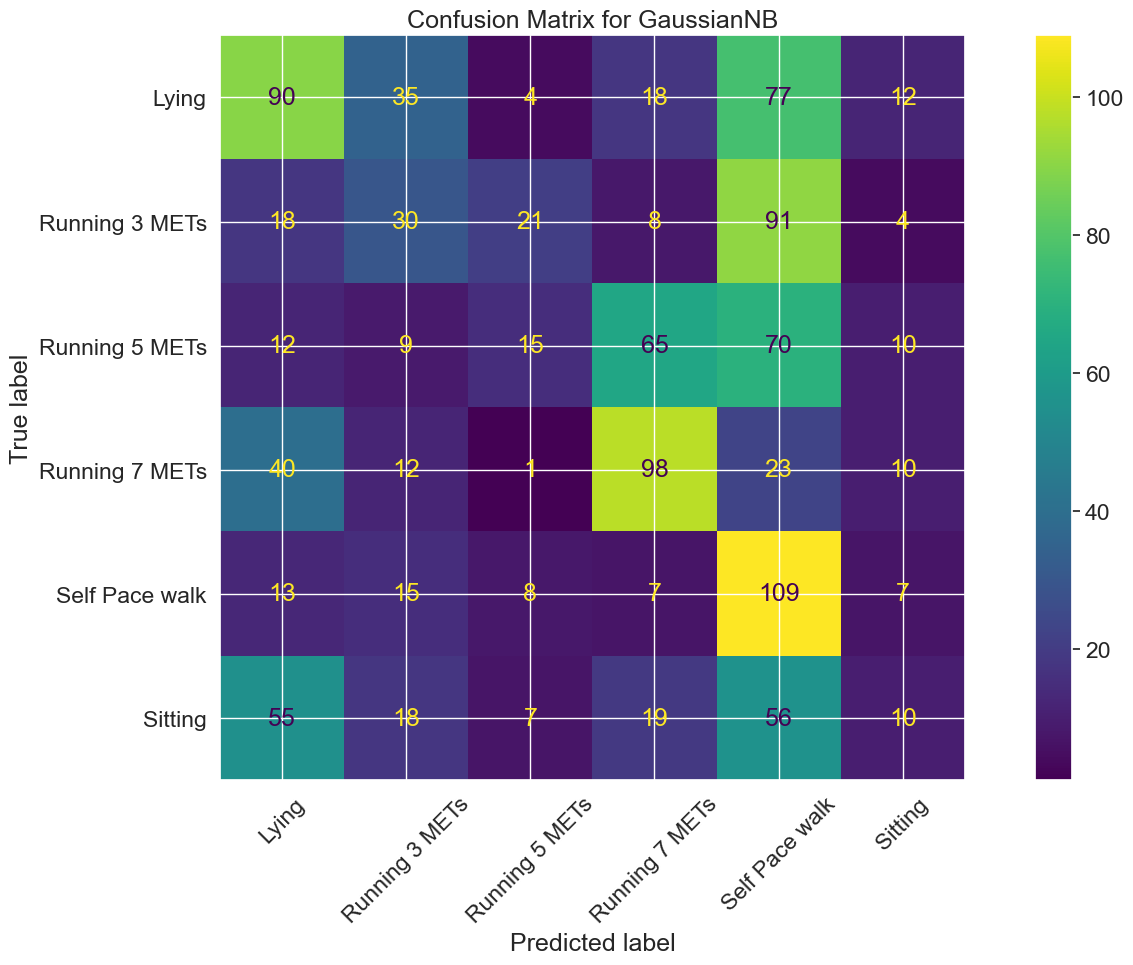

In [31]:
nb_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

Diagonal Elements: The diagonal elements represent the number of instances that were correctly classified. For example, the value 90 in the top-left cell indicates that 90 instances of the "Lying" class were correctly classified as "Lying."

Off-Diagonal Elements: The off-diagonal elements represent the number of instances that were misclassified. For example, the value 35 in the first row, second column indicates that 35 instances of the "Lying" class were incorrectly classified as 

"Running 3 METS."

Overall Performance: The overall performance of the model can be assessed by looking at the diagonal elements. A higher proportion of correct classifications on the diagonal indicates better performance.
Possible Implications

Class-Wise Performance: The confusion matrix can be used to evaluate the performance of the model on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis: The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

Model Improvement: The confusion matrix can be used to guide model improvement efforts. By identifying the classes with the highest misclassification rates, we can focus on improving the model's performance on those classes. This might involve collecting more training data, using different features, or trying different model architectures.

The Naive Bayes Classifier shows a mere 32% accuracy which is worse than both KNN and Random Forest. It appears this data does not do as well with traditional statistics based approaches. Next I will try a Gradient Boost Classifier.

 <font size="5"> Gradient Boost Pipeline Apple Watch</font> 

In [32]:
parameters = {'clf__n_estimators':[200,250] , 'clf__learning_rate':[0.5,0.1],'clf__max_features':["sqrt"], 'clf__max_depth':[10,5]}
g_boost_clf = GradientBoostingClassifier()
g_boost_model = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,g_boost_clf)
g_boost_model.create_pipeline()
grid_cv = g_boost_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [33]:
g_boost_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.78      0.81      0.80       236
Running 3 METs       0.87      0.88      0.88       172
Running 5 METs       0.89      0.85      0.87       181
Running 7 METs       0.92      0.90      0.91       184
Self Pace walk       0.84      0.82      0.83       159
       Sitting       0.72      0.75      0.73       165

      accuracy                           0.84      1097
     macro avg       0.84      0.83      0.84      1097
  weighted avg       0.84      0.84      0.84      1097



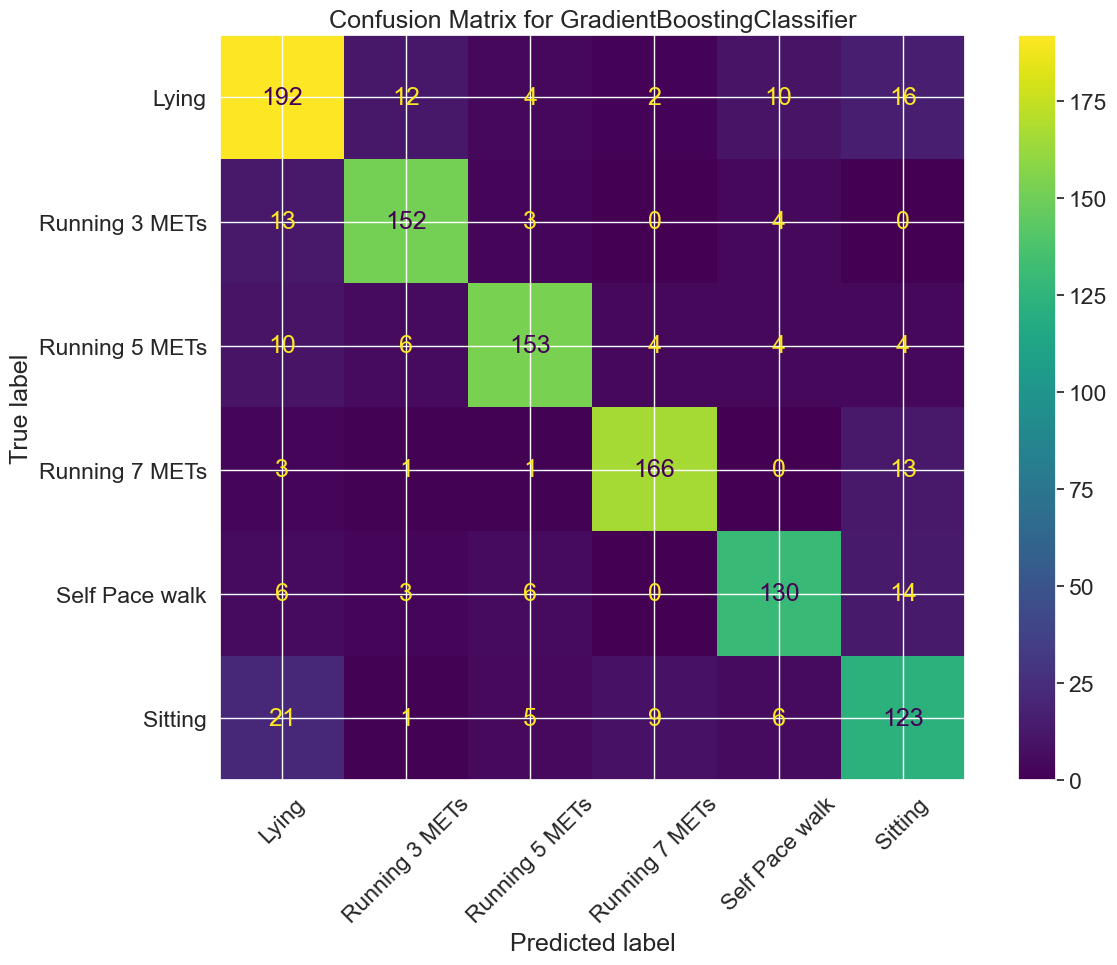

In [34]:
g_boost_model.display_confusion_matrix(font_scale=1.5,fig_size=(13,10))

Key Observations

Diagonal Elements: The diagonal elements represent the number of instances that were correctly classified. For example, the value 192 in the top-left cell indicates that 192 instances of the "Lying" class were correctly classified as "Lying."

Off-Diagonal Elements: The off-diagonal elements represent the number of instances that were misclassified. For example, the value 12 in the first row, second column indicates that 12 instances of the "Lying" class were incorrectly classified as "Running 3 METS."

Overall Performance: The overall performance of the model can be assessed by looking at the diagonal elements. A higher proportion of correct classifications on the diagonal indicates better performance.
Possible Implications

Class-Wise Performance: The confusion matrix can be used to evaluate the performance of the model on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis: The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

Model Improvement: The confusion matrix can be used to guide model improvement efforts. By identifying the classes with the highest misclassification rates, we can focus on improving the model's performance on those classes. This might involve collecting more training data, using different features, or trying different model architectures.

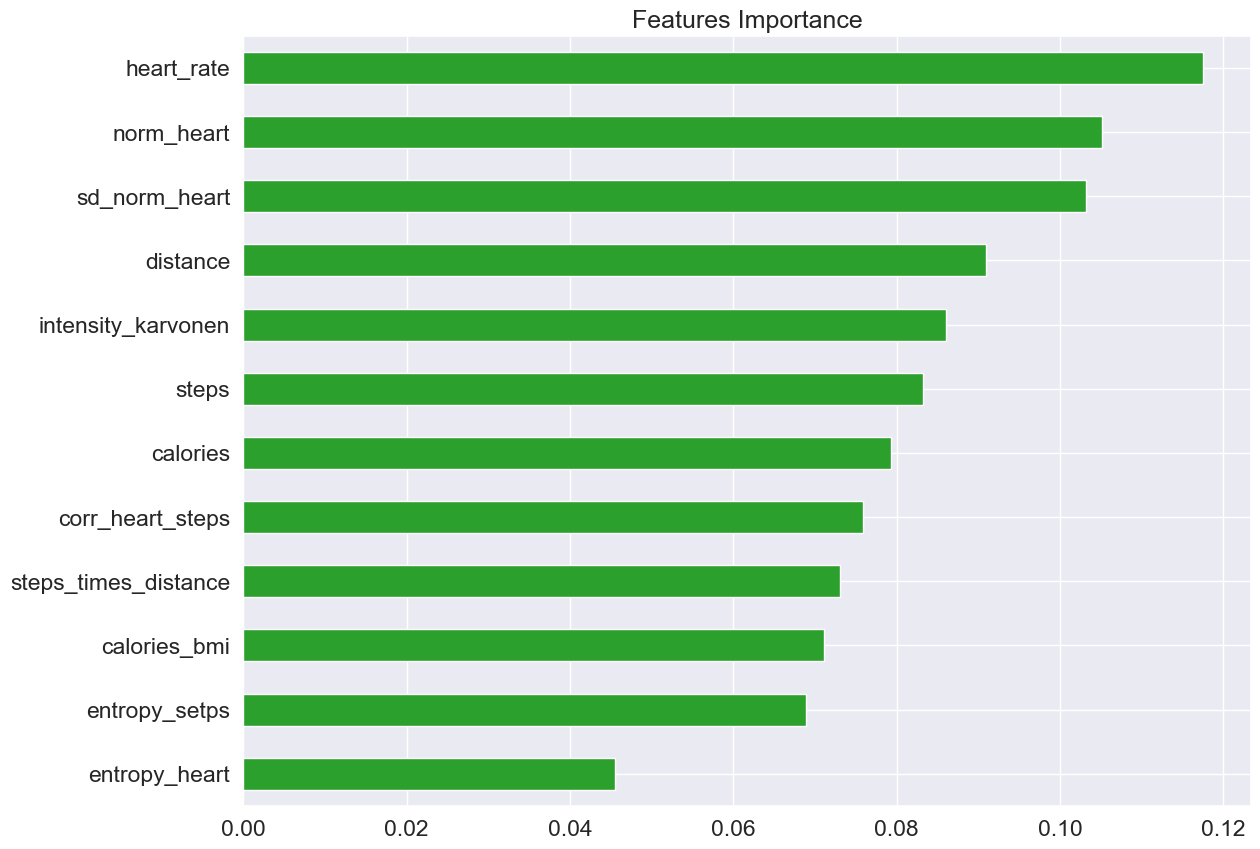

In [35]:
grid_cv.best_params_
gb_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
gb = GradientBoostingClassifier()
gb.set_params(**gb_params)
gb.fit(X_train,y_train)

importances = pd.Series(data=gb.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (13,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

Top Features:

heart_rate, norm_heart, and sd_norm_heart are the most influential features. This suggests that heart rate-related metrics are crucial for accurate activity recognition.
Feature Ranking:

The features are ranked in descending order of importance. This ranking provides a clear understanding of the relative contribution of each feature.

Gradient Boost shows an 84% accuracy with a 0.93 Precision and 0.89 recall on Running 7 Mets. 
Feature Importance also shows the heart rate variables as the ones with the highest feature importance.

 <font size="5"> EDA Fitbit</font> 

In [36]:
df_f = df[df['device'] == 'fitbit'].copy()
df_f.reset_index(drop=True,inplace=True)

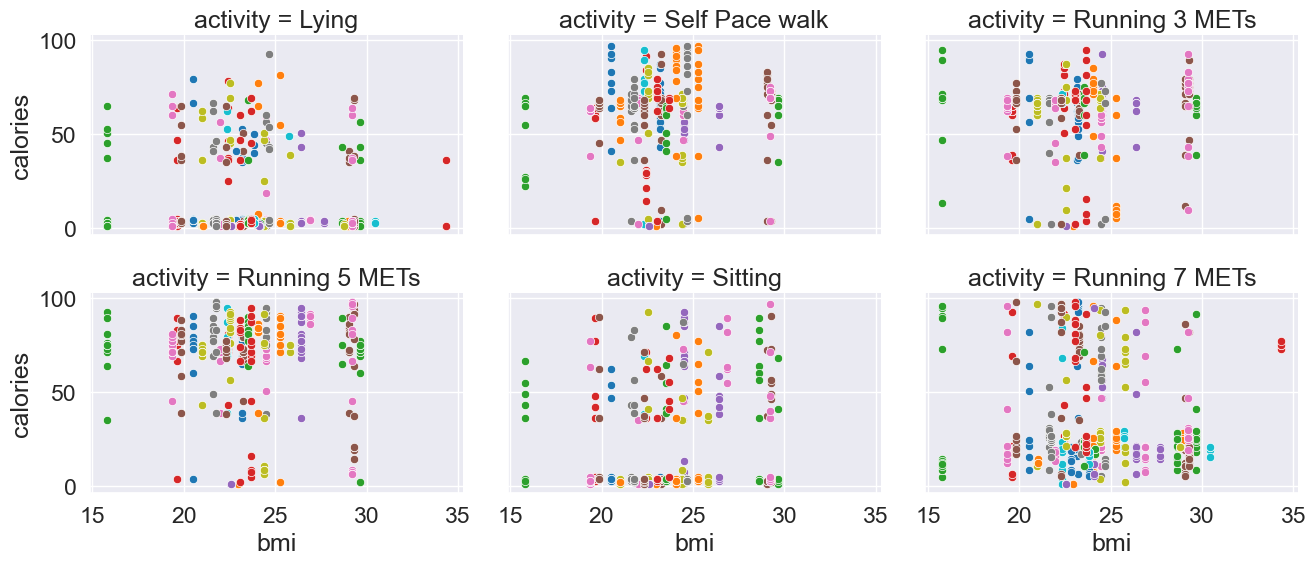

In [37]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,hue = 'person',palette = 'tab10')
g.map(sns.scatterplot,'bmi','calories' )
plt.tight_layout()

Calories vs. BMI:

There seems to be a positive correlation between calories burned and BMI for most activities. This suggests that individuals with higher BMIs tend to burn more calories, especially during activities like running.
However, the relationship is not perfectly linear, indicating that other factors might also influence calorie expenditure.

Activity-Specific Patterns:

Lying and Sitting: These activities have a relatively low range of calories burned, with most data points clustered around the lower end of the y-axis.
Self-Pace Walk: This activity shows a wider range of calorie expenditure, with some individuals burning more calories than others for the same BMI.
Running Activities: The running activities (3, 5, and 7 METS) show a clear upward trend, with higher BMI individuals generally burning more calories.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


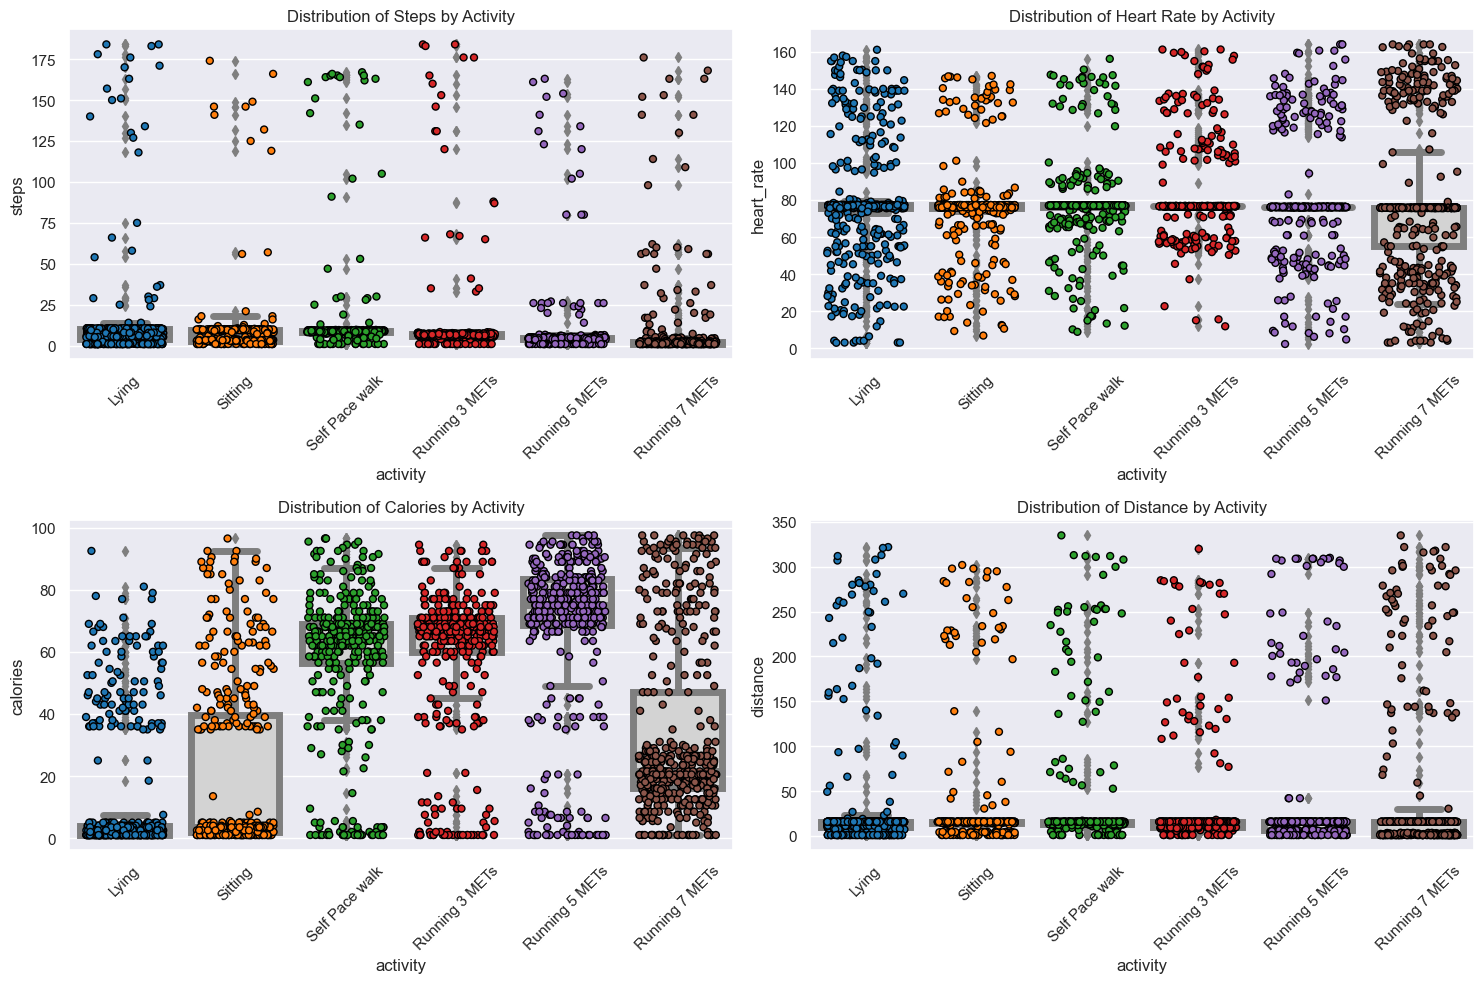

In [38]:
sns.set(font_scale=1)
params = dict(data=df_f,
              x='activity',            
              order=['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs'])
# List of Variables to Compare Distributions
distribution_vars = ['steps', 'heart_rate',
                     'calories','distance',
                     'entropy_heart','calories_bmi',
                     'corr_heart_steps','norm_heart', 
                     'intensity_karvonen','sd_norm_heart', ] 
grid_strip_box(2,2,(15,10),var_list=distribution_vars[0:4],**params)

Distribution of Steps:

Lying and Sitting: 

These activities have minimal steps, as expected.
Self-Pace Walk: Shows a moderate range of steps, with some individuals taking more steps than others.
Running Activities: The running activities (3, 5, and 7 METS) have significantly higher step counts, with the distribution increasing as the intensity level rises.
Distribution of Heart Rate:

Lying and Sitting: 
    
These activities have lower heart rates, with minimal variability.
Self-Pace Walk: Shows a moderate range of heart rates.
Running Activities: The running activities exhibit increasing heart rates with higher intensity levels.
Distribution of Calories:

Lying and Sitting:
    
These activities have minimal calorie burn.
Self-Pace Walk: Shows a moderate range of calorie expenditure.
Running Activities: The running activities have significantly higher calorie burn, with the distribution increasing with intensity.
Distribution of Distance:

Lying and Sitting: 
    
Minimal distance covered.

Self-Pace Walk: 
    
A moderate range of distances.
Running Activities: Increasing distance covered with higher intensity levels.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


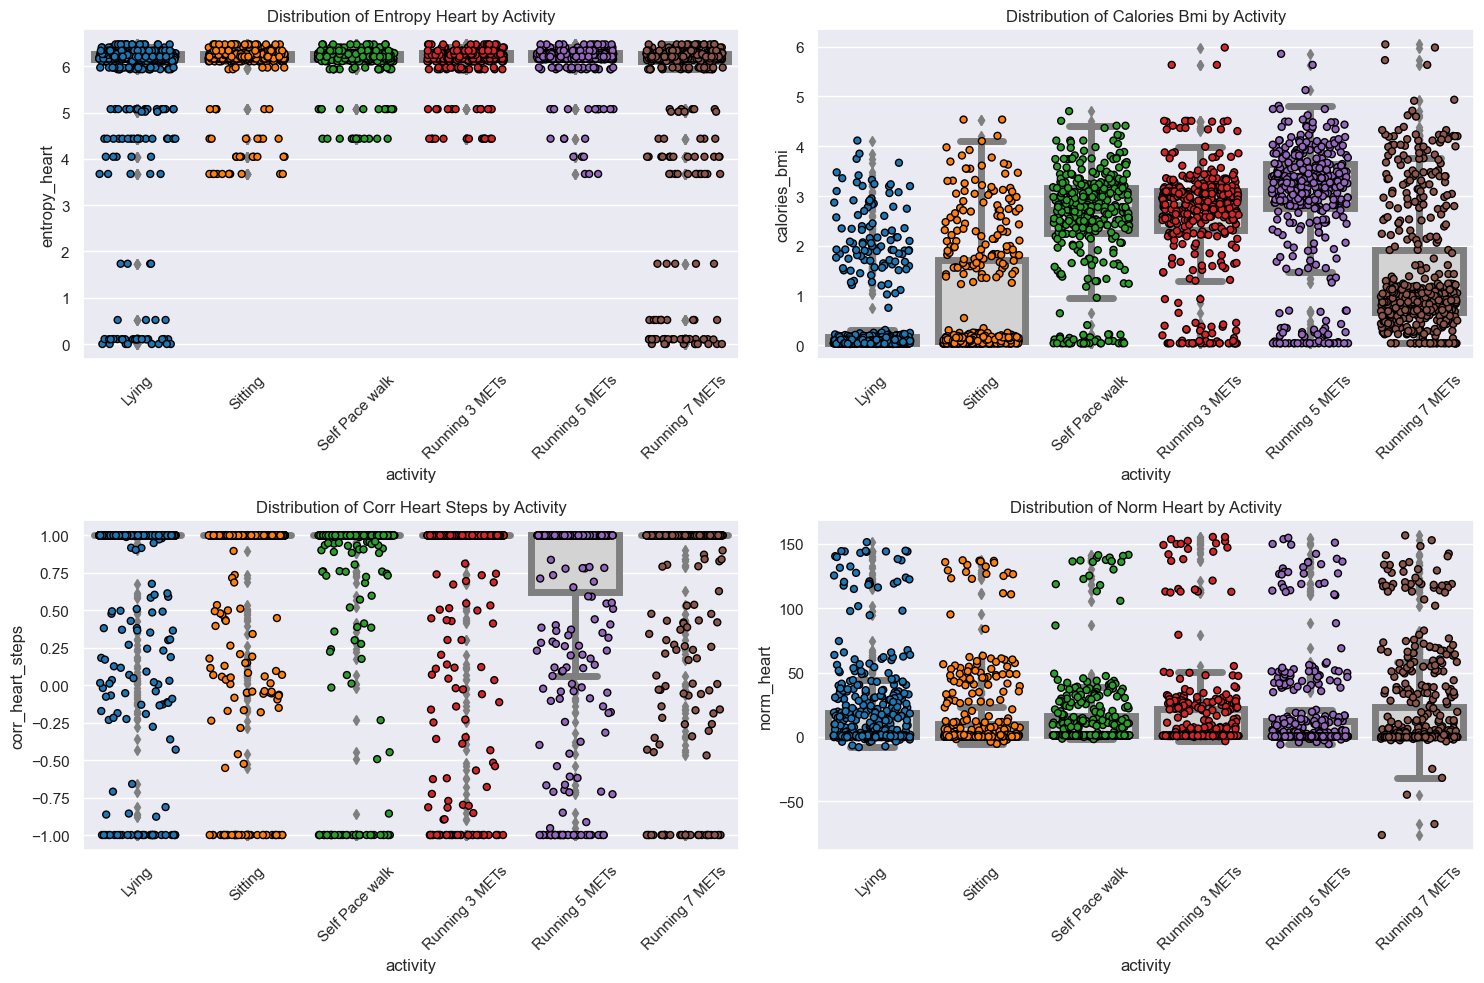

In [39]:
grid_strip_box(2,2,(15,10),var_list=distribution_vars[4:9],**params)

Entropy Heart:

Lying and Sitting: Low entropy values, indicating less variability in heart rate patterns.
Self-Pace Walk: Moderate entropy values, suggesting some variability in heart rate patterns.
Running Activities: Higher entropy values, indicating significant variability in heart rate patterns during physical exertion.
Calories BMI:

Lying and Sitting: Low values, reflecting minimal calorie burn during these activities.
Self-Pace Walk: Moderate values, indicating some calorie expenditure.
Running Activities: Higher values, reflecting increased calorie burn with higher intensity levels.
Corr Heart Steps:

Lying and Sitting: Low correlation, as heart rate and steps are not strongly related during these activities.
Self-Pace Walk and Running Activities: Higher correlation, indicating a stronger relationship between heart rate and steps during physical activity.
Norm Heart:

Lying and Sitting: Lower normalized heart rate values.
Self-Pace Walk and Running Activities: Higher normalized heart rate values, reflecting increased heart rate during physical activity.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\397461938.py:130: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


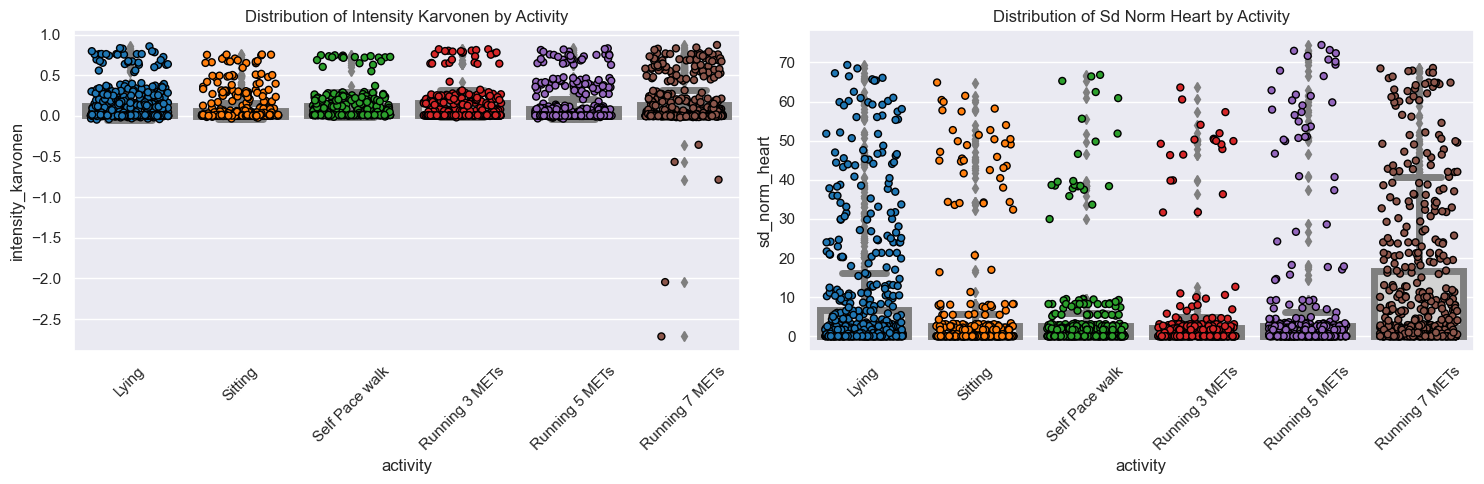

In [40]:
grid_strip_box(1,2,(15,5),var_list=distribution_vars[8:],**params)

Intensity Karvonen:

Lying and Sitting: Low intensity values, indicating minimal physical exertion.
Self-Pace Walk: Moderate intensity values, reflecting light physical activity.
Running Activities: High intensity values, increasing with higher intensity levels.
Observation: The distribution of intensity_karvonen is skewed towards higher values for running activities, suggesting that these activities are characterized by higher intensity levels.
SD Norm Heart:

Lying and Sitting: Low standard deviation values, indicating less variability in normalized heart rate.
Self-Pace Walk: Moderate standard deviation values, suggesting some variability in heart rate during walking.
Running Activities: Higher standard deviation values, indicating significant variability in heart rate during physical exertion.
Observation: The distribution of sd_norm_heart is skewed towards higher values for running activities, suggesting that these activities are associated with greater variability in heart rate.

    
Interestingly, the Fitbit data seems to show more separation on calories, distance and steps across the activities where Apple Watch showed heart rate to be a stronger separator.

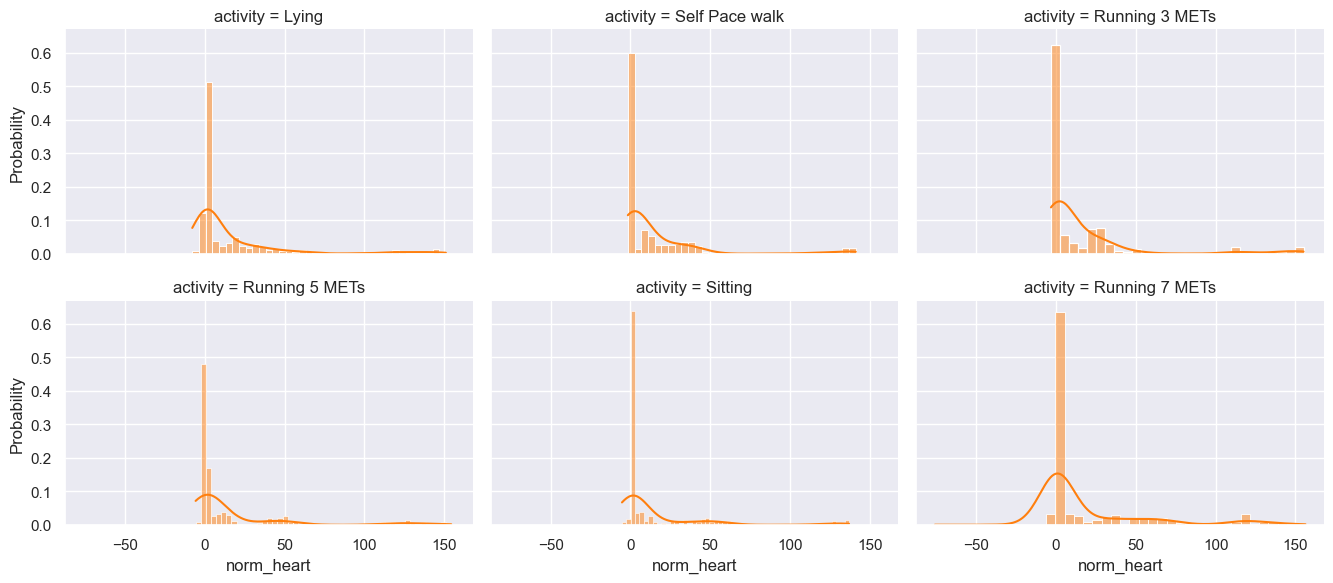

In [41]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'norm_heart', kde =True , color = '#ff7f0e', stat='probability')
plt.tight_layout()

Activity-Specific Distributions:

Lying and Sitting: These activities exhibit lower norm_heart values, with the distribution concentrated around 0.
Self-Pace Walk: A wider range of norm_heart values, with a peak around 50.

Running Activities: Higher norm_heart values, with the distribution shifting towards higher values as the intensity increases.

Outliers and Anomalies:

There are some outliers present in the data, especially for the running activities. These outliers might represent unusual heart rate patterns or measurement errors.

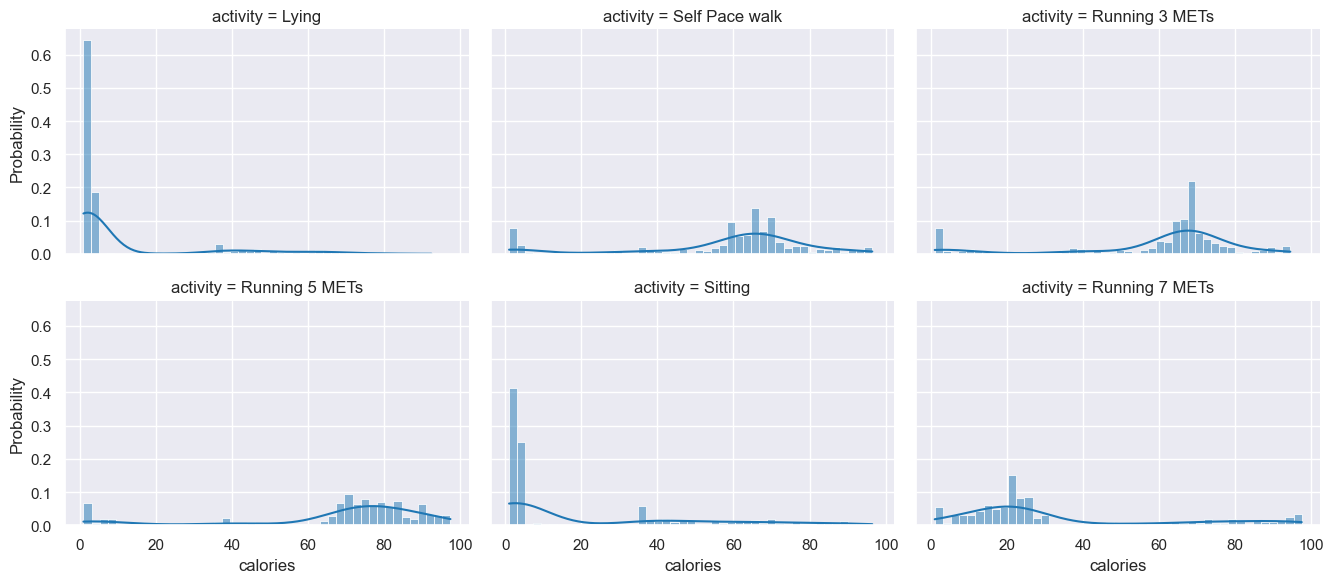

In [42]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'calories', kde =True , color = '#1f77b4', stat='probability',bins=45)
plt.tight_layout()

Activity-Specific Distributions:

Lying and Sitting: Low calorie values, with the distribution concentrated around 0.
Self-Pace Walk: A wider range of calorie values, with a peak around 20-30.
Running Activities: Higher calorie values, with the distribution shifting towards higher values as the intensity increases.
Outliers and Anomalies:

There are some outliers present in the data, especially for the running activities. These outliers might represent unusual calorie expenditure or measurement errors.

C:\Users\delmo\AppData\Local\Temp\ipykernel_3328\2105116034.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_f.corr(),annot=True,fmt='.2f')


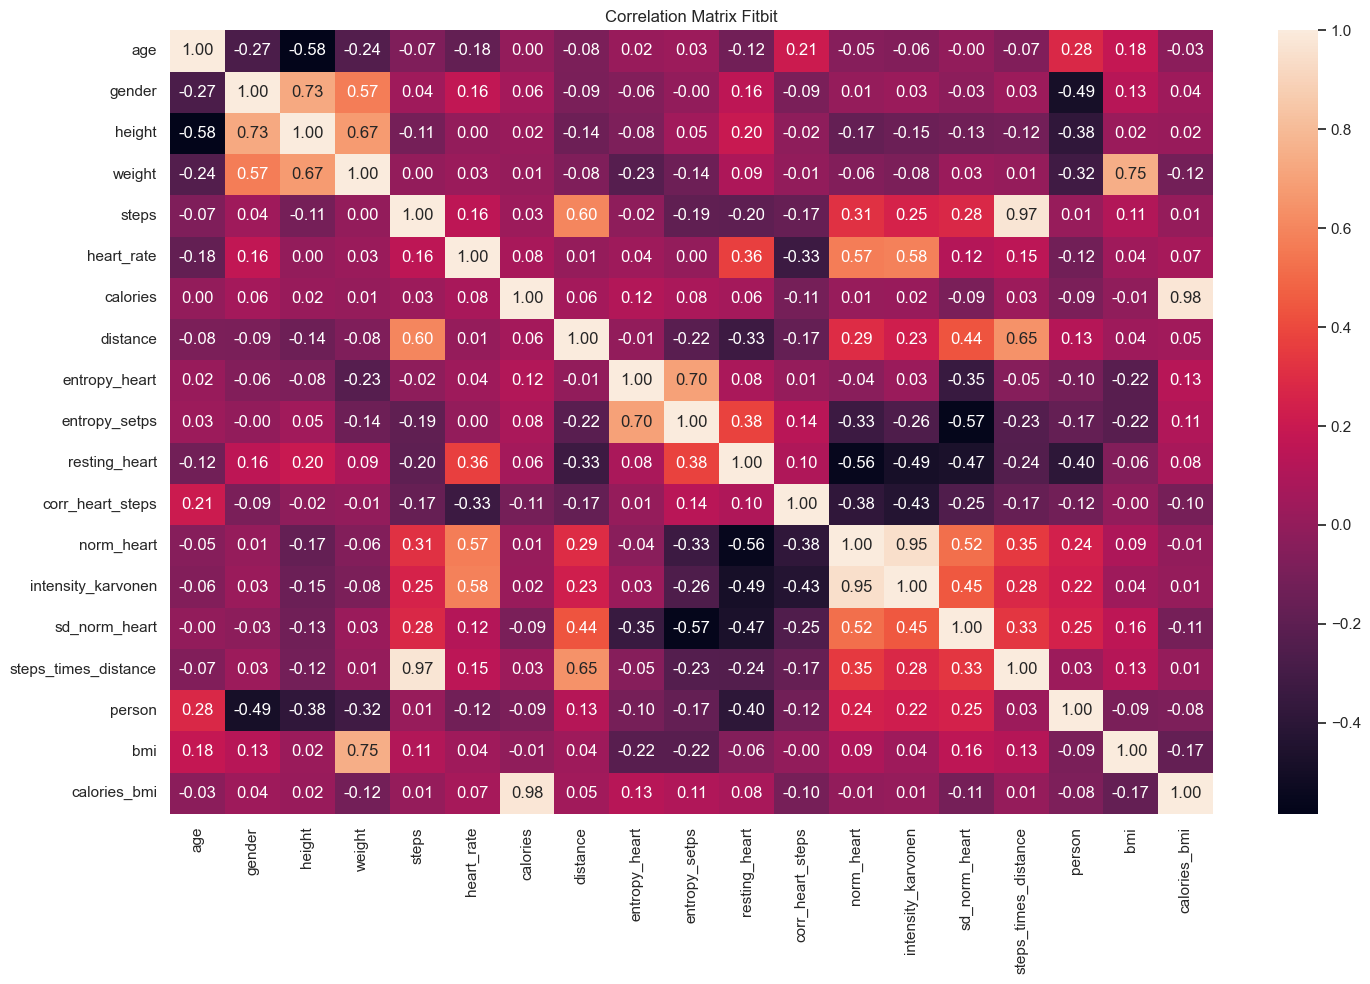

In [43]:
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
sns.heatmap(df_f.corr(),annot=True,fmt='.2f')
plt.title('Correlation Matrix Fitbit')
plt.tight_layout()

Strong Positive Correlations:

Height and Weight: There's a strong positive correlation between height and weight, which is expected as taller individuals tend to weigh more.
Steps and Distance: A strong positive correlation indicates that as the number of steps increases, the distance covered also increases.
Heart Rate and Intensity Karvonen: A strong positive correlation suggests that higher heart rates are associated with higher intensity levels.
Norm Heart and SD Norm Heart: A strong positive correlation indicates that higher normalized heart rate values are associated with greater variability in heart rate.
Strong Negative Correlations:

Entropy Heart and Resting Heart: A strong negative correlation suggests that higher heart rate variability is associated with lower resting heart rates.
Entropy Selfps and Corr Heart Steps: A strong negative correlation indicates that higher heart rate variability is associated with lower correlation between heart rate and steps.
    
Distance and steps show a weaker correlation on the Fitbit data. Looking at the data, it also appears the units on distance and steps are different between the 2 devices.

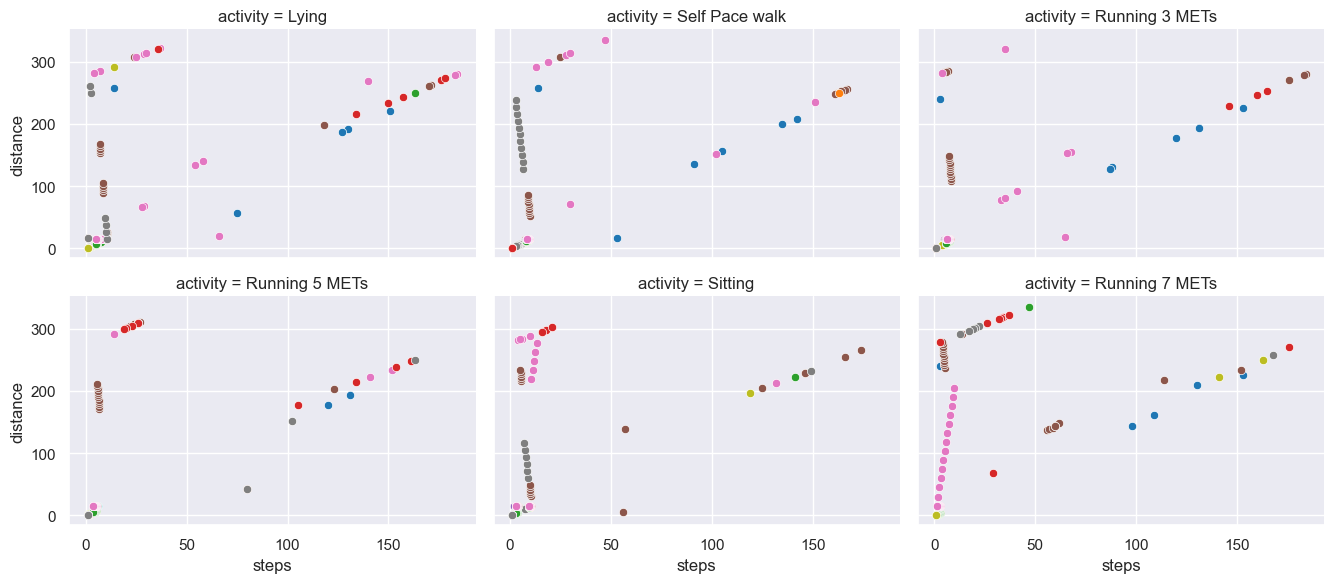

In [44]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,hue = 'person',palette = 'tab10')
g.map(sns.scatterplot,'steps','distance' )
plt.tight_layout()

Positive Correlation: In all activity types, there is a clear positive correlation between "steps" and "distance." As the number of steps increases, the distance covered also increases. This is expected, as more steps generally lead to a longer distance.

Activity-Specific Patterns: While the overall trend is similar across all activities, there are some activity-specific patterns:

Lying: This activity shows a very low range of both steps and distance, as expected. Most data points are clustered near the origin.
Self-Pace Walk: This activity shows a moderate range of steps and distance, with a relatively linear relationship between the two variables.
Running 3 METS: This activity shows a wider range of steps and distance compared to self-pace walk, with some data points extending to higher values.
Running 5 METS: This activity shows an even wider range of steps and distance compared to running 3 METS, with some data points reaching higher values.
Sitting: Similar to lying, this activity shows a very low range of both steps and distance, with most data points clustered near the origin.
Running 7 METS: This activity shows the widest range of steps and distance among all activities, with some data points reaching very high values.
Actionable Insights:

Feature Engineering: The strong positive correlation between steps and distance suggests that these two features might be highly correlated. Consider using feature engineering techniques to create new features that capture the relationship between these variables in a more informative way. For example, you could calculate the average step length or the average speed for each activity.
Outlier Detection: Some data points might appear as outliers in certain plots. These outliers could be due to measurement errors, unusual behavior, or other factors. It's important to investigate these outliers to understand their cause and decide whether to remove them or treat them differently.
Activity Classification: The different patterns observed in the plots can be used to help classify activities. For example, activities with low steps and distance are likely to be "lying" or "sitting," while activities with high steps and distance are likely to be "running."
Model Training: These plots can be used to visualize the distribution of data points for different activity types. This information can be useful for training machine learning models to classify activities based on sensor data.

It looks like in some of the Fitbit data there is some of the positive correlation we would expect to see, but it also looks like there is a lot of noise.

 <font size="5"> Training and Validation Fitbit</font> 

In [45]:
predictor_list = [col for col in df_f.columns if col not in ['activity','age', 'gender', 'height', 'weight','bmi','device','person','resting_heart']]

X = df_f[predictor_list]
y = df_f['activity']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , random_state = 42 , stratify=y)


 <font size="5"> PCA Fitbit</font> 

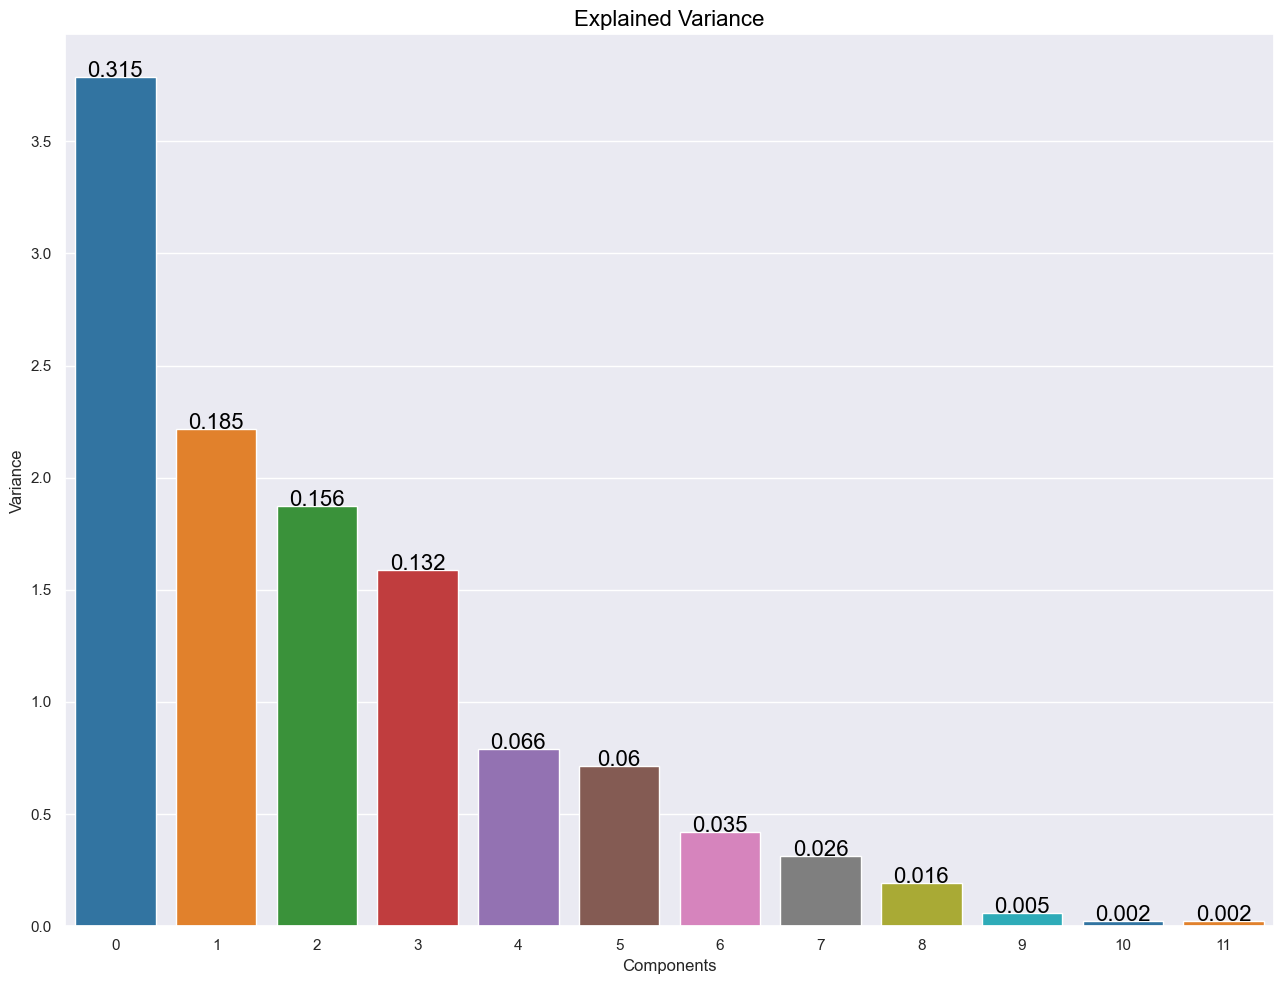

In [46]:
X_train_scaled = scale_data(X_train)
from sklearn.decomposition import PCA
plt.figure(figsize = (13,10))
pca = PCA()
pca.fit(scale_data(X_train_scaled)) 
components = range(pca.n_components_)
plot_comp_df = pd.DataFrame({'Components':components, 'Variance':pca.explained_variance_})
bp = sns.barplot(x = 'Components',y = 'Variance',data = plot_comp_df , palette = 'tab10')
variance_ratios = [round(float(ratio),3) for ratio in pca.explained_variance_ratio_]

font = {'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


for component,variance,ratio in zip(components , pca.explained_variance_ ,variance_ratios):
    bp.text(x=component,y=variance,s=ratio,ha="center",fontdict = font)

plt.title('Explained Variance',fontdict = font)
plt.tight_layout()

Key Insights from the Plot:

PC1: This component explains the largest amount of variance in the data (approximately 31.5%). This suggests that PC1 captures the most significant patterns or trends in the data.
PC2: This component explains the second largest amount of variance (approximately 18.5%). It captures the second most important pattern in the data.
Subsequent PCs: The remaining PCs explain progressively smaller amounts of variance. For example, PC3 explains around 15.6% of the variance, while PC4 explains around 13.2%.
Actionable Insights:

Dimensionality Reduction: PCA can be used to reduce the dimensionality of the dataset while preserving most of the information. By selecting a subset of the principal components with the highest explained variance, you can effectively reduce the number of features in the data.
Feature Importance: The principal components can be used to identify the most important features in the dataset. The features that have the highest loadings on the principal components with high explained variance are likely to be the most informative.
Data Visualization: Principal components can be used to visualize high-dimensional data in a lower-dimensional space. This can help to identify patterns, clusters, and outliers that might not be apparent in the original data.
Model Building: Principal components can be used as input features for machine learning models. This can improve the performance of the models, especially when dealing with high-dimensional data.

In [47]:
np.cumsum(pca.explained_variance_ratio_)

array([0.31546937, 0.50021508, 0.6563211 , 0.7886822 , 0.85432417,
       0.9139484 , 0.94889331, 0.97503234, 0.99117382, 0.99599579,
       0.99808874, 1.        ])

C:\Users\delmo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


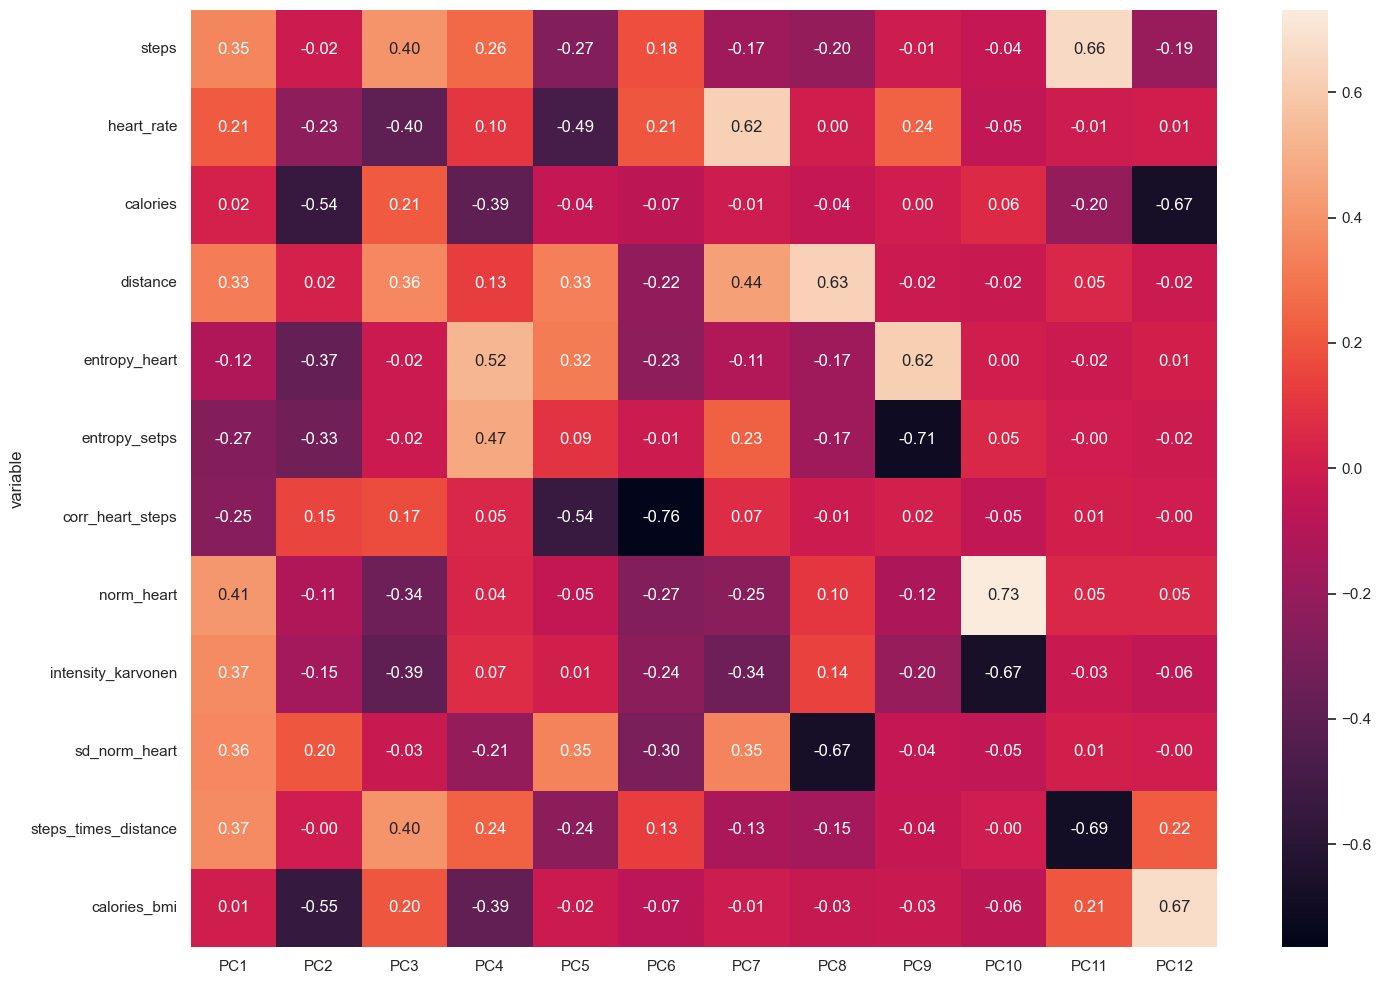

In [48]:
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
loadings = pca.components_
n_comp = pca.n_features_
pc_list = ["PC"+str(i) for i in range(1,n_comp+1)]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_train.columns.values
loadings_df = loadings_df.set_index('variable')
sns.heatmap(loadings_df ,annot=True,fmt='.2f')
plt.tight_layout()

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a dataset with many features into a dataset with fewer features called principal components. Each principal component is a linear combination of the original features.

Correlation with Principal Components:

Steps: This feature has a strong positive correlation with PC1. This suggests that PC1 captures a significant portion of the variation in the number of steps.
Heart Rate: This feature has a strong positive correlation with PC2 and PC3. This indicates that PC2 and PC3 capture information related to heart rate.
Calories: This feature has a strong negative correlation with PC2 and a strong positive correlation with PC12. This suggests that PC2 and PC12 capture different aspects of calorie expenditure.
Distance: This feature has a strong positive correlation with PC1 and PC7. This indicates that PC1 and PC7 capture information related to distance traveled.
Entropy Heart: This feature has a strong positive correlation with PC4 and PC7. This suggests that PC4 and PC7 capture information related to the variability of heart rate.
Actionable Insights:

Feature Importance: The strength of the correlation between a feature and a principal component can be used to assess the importance of that feature in explaining the variation in the data.
Dimensionality Reduction: PCA can be used to reduce the dimensionality of the dataset while preserving most of the information. This can improve the performance of machine learning models, especially when dealing with high-dimensional data.
Model Interpretation: By understanding the relationship between the principal components and the original features, we can gain insights into the underlying patterns in the data and improve model interpretability.

 <font size="5"> K Means Fitbit</font> 

In [49]:
k_s = list(range(2,len(y_train.unique() ) + 3))
inertias = [calculate_inertia(k,X_train_scaled) for k in k_s]

C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

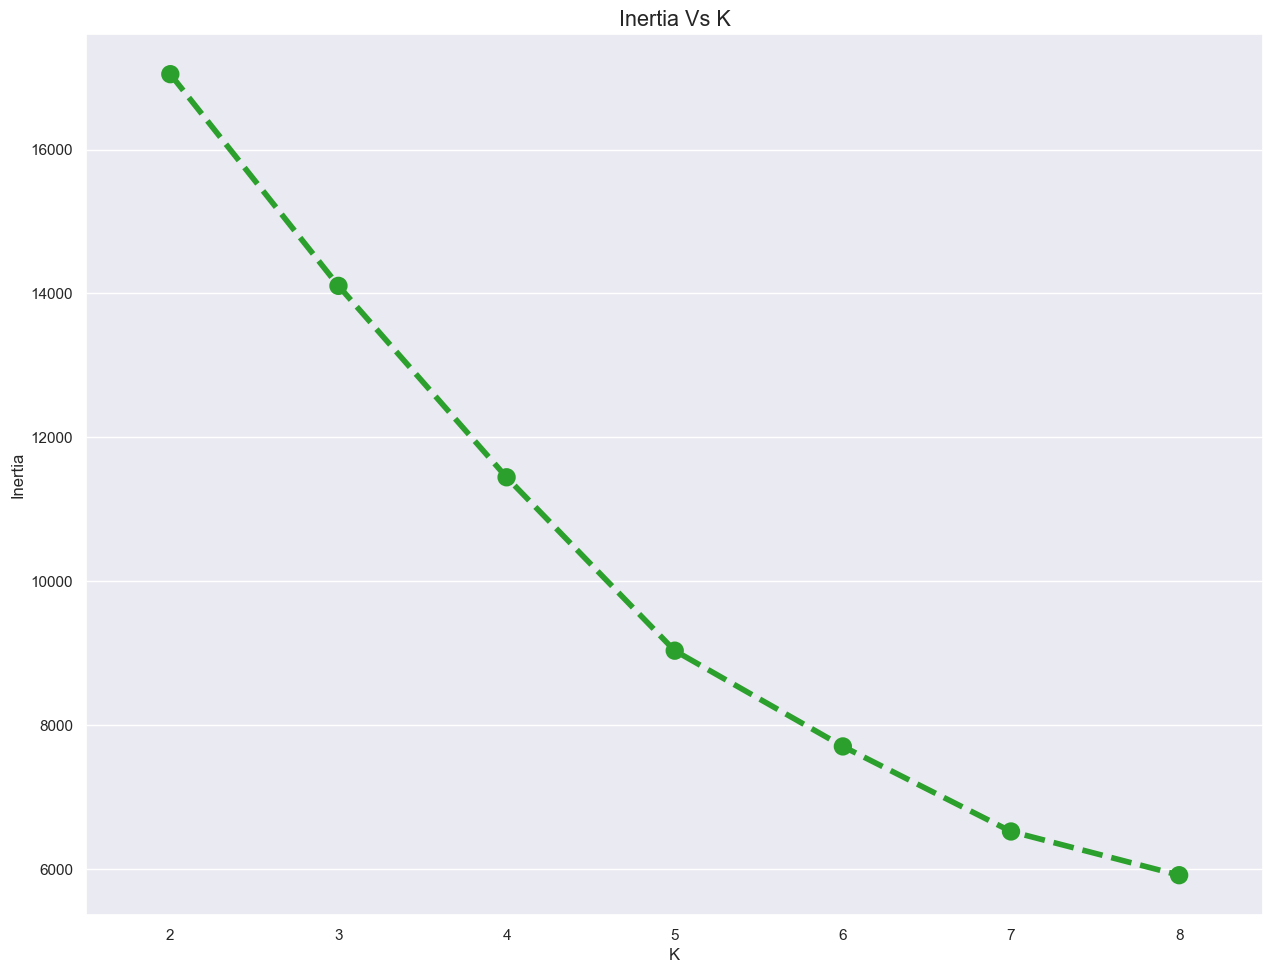

In [50]:
plt.figure(figsize = (13,10))
sns.pointplot(x=k_s,y=inertias , linestyles ='--',markers = 'o',scale=1.5, color='#2ca02c')
sns.set(font_scale=1.3)
plt.title('Inertia Vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout()

Inertia Trend: As the number of clusters (K) increases, the inertia generally decreases. This is because with more clusters, the data points can be assigned to closer clusters, leading to lower within-cluster variation.

Elbow Point: The elbow point is a point on the curve where the rate of decrease in inertia starts to slow down significantly. This point often suggests an optimal number of clusters. In this plot, the elbow point appears to be around K=5 or K=6.

Actionable Insights:

Choosing the Optimal Number of Clusters:

Elbow Method: Use the elbow point as a guideline to select the optimal number of clusters. In this case, K=5 or K=6 could be good choices.
Silhouette Score: Calculate the silhouette score for different values of K to evaluate the quality of clustering. The higher the silhouette score, the better the clustering.
Domain Knowledge: Consider the specific domain of your data and the desired interpretation of clusters. Sometimes, a higher or lower number of clusters might be more appropriate based on domain expertise.
Improving Clustering:

Feature Scaling: If the features have different scales, consider scaling them to improve the performance of the clustering algorithm.
Feature Engineering: Create new features that might better capture the underlying structure of the data.
Alternative Clustering Algorithms: Explore other clustering algorithms like DBSCAN or hierarchical clustering to see if they provide better results.

In [51]:
model_kmeans = KMeans(n_clusters = 5 , random_state=40)
model_kmeans.fit_predict(X_train_scaled)
clusters = pd.Series( model_kmeans.fit_predict(X_train_scaled)).rename('clusters',inplace= True)

C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\delmo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

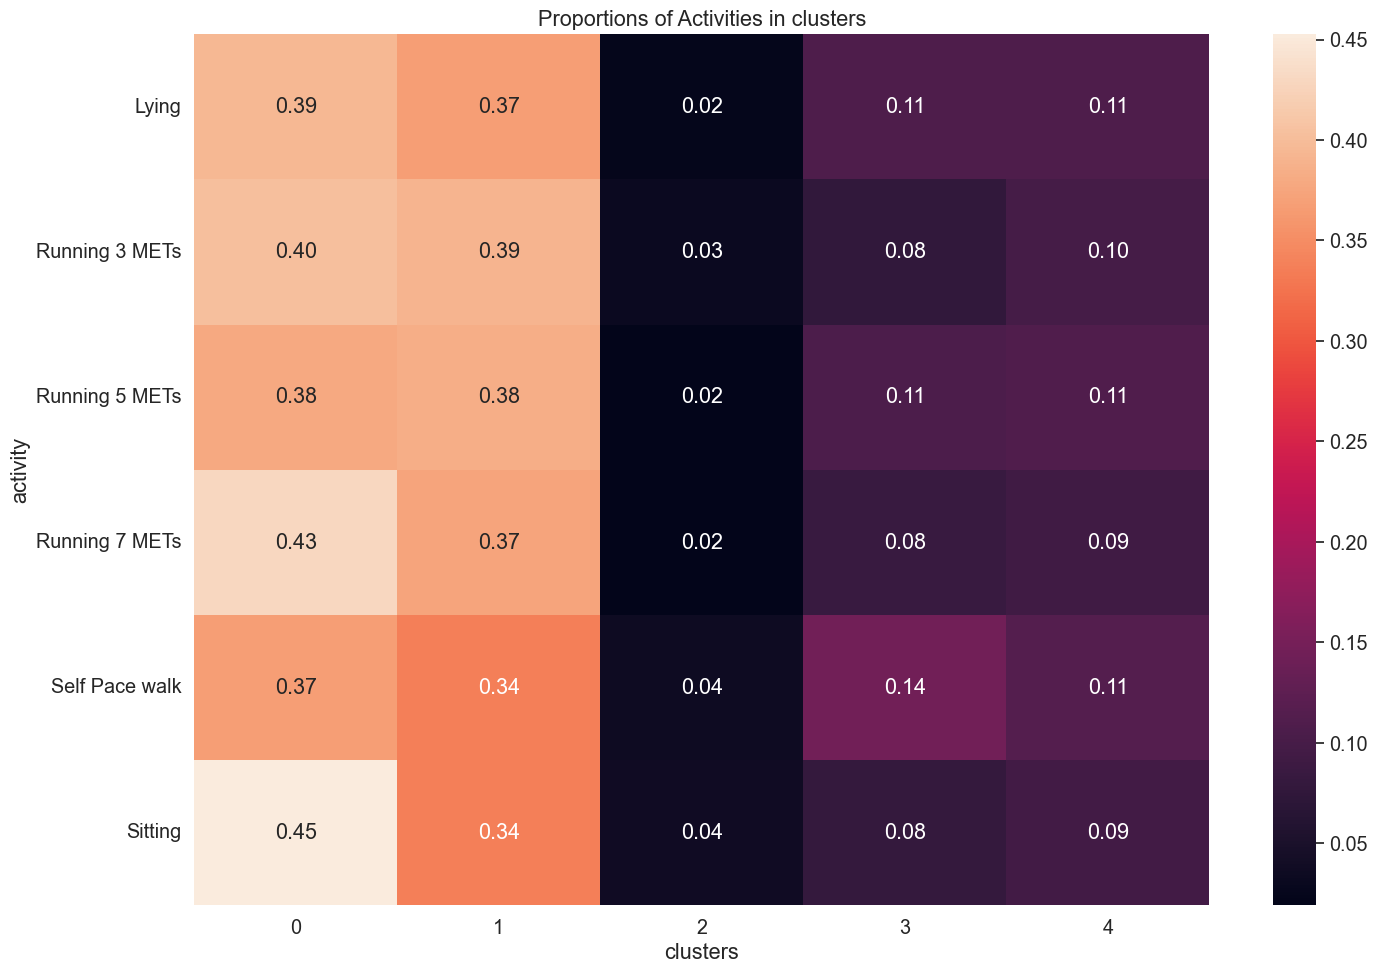

In [52]:
plt.figure(figsize = (15,10))
cross_tab = pd.crosstab(y_train,clusters,normalize=False)
row_sums = cross_tab.values.sum(axis=1)
proportions = cross_tab / row_sums.reshape((6,1))
sns.heatmap(proportions,annot=True,fmt='.2f')
plt.title('Proportions of Activities in clusters')
plt.tight_layout()

Key Insights from the Heatmap:

Cluster 0:

Dominated by lying activities.
Has a significant presence of "Running 3 METS" and "Running 5 METS."
Cluster 1:

Predominantly consists of "Running 3 METS" and "Running 5 METS."
Also has a moderate presence of "Lying" and "Sitting."
Cluster 2:

Primarily contains "Running 7 METS" and "Self Pace Walk."
Has a smaller proportion of "Lying" and "Sitting."
Cluster 3:

Characterized by "Self Pace Walk" and "Sitting."
Also has a noticeable presence of "Running 7 METS."
Cluster 4:

Primarily composed of "Sitting" activities.
Has a moderate presence of "Self Pace Walk" and "Running 7 METS."
Actionable Insights:

Cluster Analysis:

Identify the key features that differentiate each cluster. This could be done using techniques like t-SNE or UMAP for dimensionality reduction and visualization.
Analyze the distribution of other relevant features (e.g., heart rate, step count, etc.) within each cluster to gain further insights.
Model Improvement:

Incorporate cluster information as a feature in your machine learning model. This could improve the model's ability to distinguish between similar activities.
Use clustering as a preprocessing step to group similar activities together, which could simplify the classification task.
Activity Recognition:

Develop activity recognition systems that can accurately identify the activity based on the cluster information.
Use the cluster assignments to provide more granular activity labels (e.g., "lying", "light running", "moderate running", "brisk walking", "sitting").
Remember: The interpretation of cluster assignments depends on the specific features used for clustering and the domain knowledge of the application. It's important to validate the results using domain expertise and external evaluation metrics.

From the Elbow plot of the inertia score it looks like 5 cluster is ideal. From the cluster crosstab It does look like the Lying activity lines up slightly more with cluster 1.

 <font size="5"> Random Forest Pipeline Fitbit</font> 

In [53]:
parameters = {'clf__criterion':['entropy','gini'] , 'clf__max_depth':[80,100] , 'clf__n_estimators':[100,120],"clf__max_features":['sqrt', 'log2']}
rf_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,RandomForestClassifier())
grid_cv = rf_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

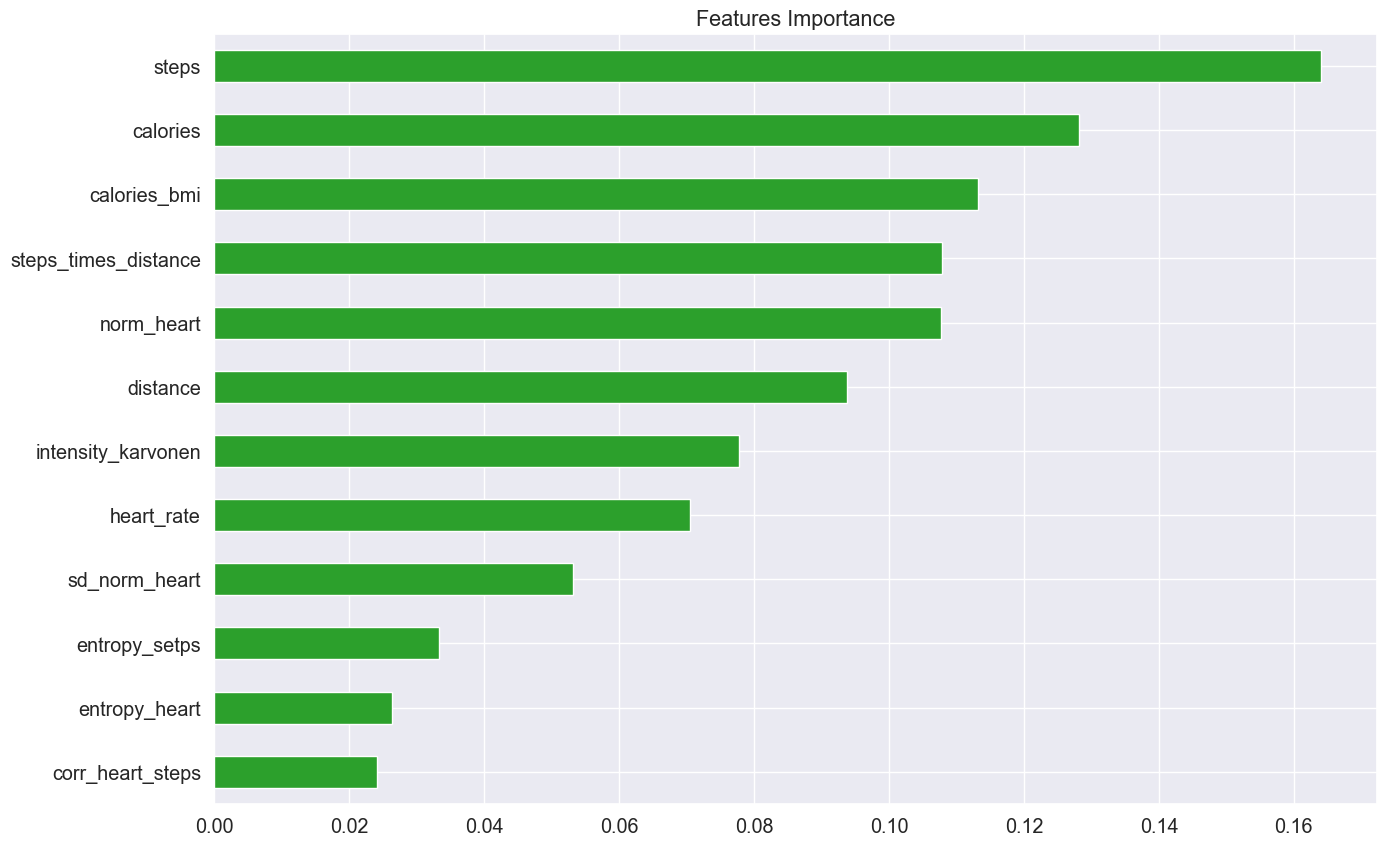

In [54]:
grid_cv.best_params_
rf_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
rf = RandomForestClassifier()
rf.set_params(**rf_params)
rf.fit(X_train,y_train)

importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

Top Features:

steps: This feature has the highest importance, indicating that the number of steps taken during an activity is a strong predictor of the activity type.

calories: The number of calories burned is also a significant factor in determining the activity.

calories_bmi: This feature likely captures the energy expenditure relative to body weight, which could be informative for certain activities.

Moderately Important Features:


steps_times_distance: This feature might capture the intensity of the activity by combining steps and distance.

norm_heart: Normalized heart rate could provide insights into the cardiovascular effort during the activity.

distance: The total distance covered during the activity is also a relevant factor.

Less Important Features:


intensity_karvonen: This feature, which measures intensity based on heart rate and other factors, appears to be less informative.

heart_rate: Raw heart rate might be less relevant compared to normalized heart rate.

sd_norm_heart: Standard deviation of normalized heart rate might not be a strong predictor.

entropy_steps, entropy_heart, corr_heart_steps: These features related to entropy and correlation might not carry significant predictive power.

In [55]:
rf_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.85      0.84      0.85       178
Running 3 METs       0.87      0.93      0.90       114
Running 5 METs       0.89      0.92      0.90       120
Running 7 METs       0.97      0.93      0.95       150
Self Pace walk       0.87      0.85      0.86       108
       Sitting       0.84      0.81      0.83       113

      accuracy                           0.88       783
     macro avg       0.88      0.88      0.88       783
  weighted avg       0.88      0.88      0.88       783



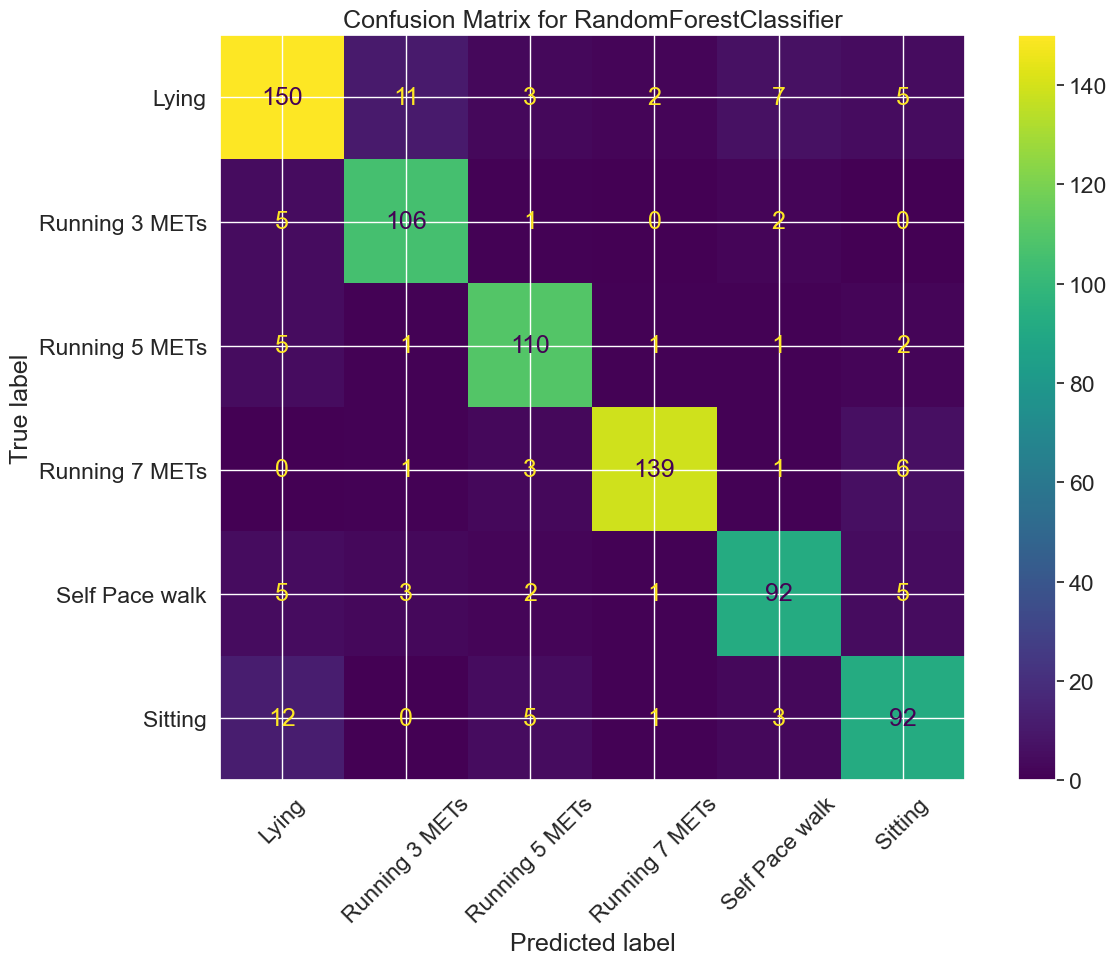

In [56]:
rf_model.display_confusion_matrix(1.5 , (13,10))

Overall Performance: The diagonal elements show the number of correct predictions for each class. A higher value on the diagonal indicates better performance for that class.

Class-wise Performance:

Lying: The model seems to be quite accurate in identifying lying instances. However, it misclassifies some instances as "Running 3 METS."
Running 3 METS: The model performs well for this class, with most instances being correctly classified.
Running 5 METS: The model also performs well for this class, with some misclassifications into "Running 7 METS."
Running 7 METS: Similar to the previous class, the model performs well with some misclassifications into "Running 5 METS" and "Self Pace walk."
Self Pace walk: The model has a good performance for this class, with some misclassifications into "Running 7 METS."
Sitting: The model is quite accurate in identifying sitting instances, with a few misclassifications into "Lying."
Error Analysis: The off-diagonal elements reveal the types of errors the model makes. For example, the model often confuses "Running 5 METS" with "Running 7 METS."

The Random Forest showed an 89% accuracy on the validation set with a 0.95 precision and 0.95 recall on the 7 Mets activity on the fitbit data. Interestingly, the fitbit data showed steps and calories to be the most important features where as Apple Watch showed variables related to heart rate.

 <font size="5"> KNN Pipeline Fitbit</font> 

In [57]:
parameters = {'clf__n_neighbors':list(range(3,15,1)),'clf__metric':['euclidean']}
steps = [('scale',StandardScaler()),('KNN',KNeighborsClassifier())]

knn_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,KNeighborsClassifier())
knn_model.create_pipeline()
grid_cv = knn_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [58]:
knn_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.77      0.80      0.79       178
Running 3 METs       0.81      0.84      0.82       114
Running 5 METs       0.82      0.88      0.85       120
Running 7 METs       0.85      0.79      0.82       150
Self Pace walk       0.80      0.81      0.81       108
       Sitting       0.76      0.68      0.72       113

      accuracy                           0.80       783
     macro avg       0.80      0.80      0.80       783
  weighted avg       0.80      0.80      0.80       783



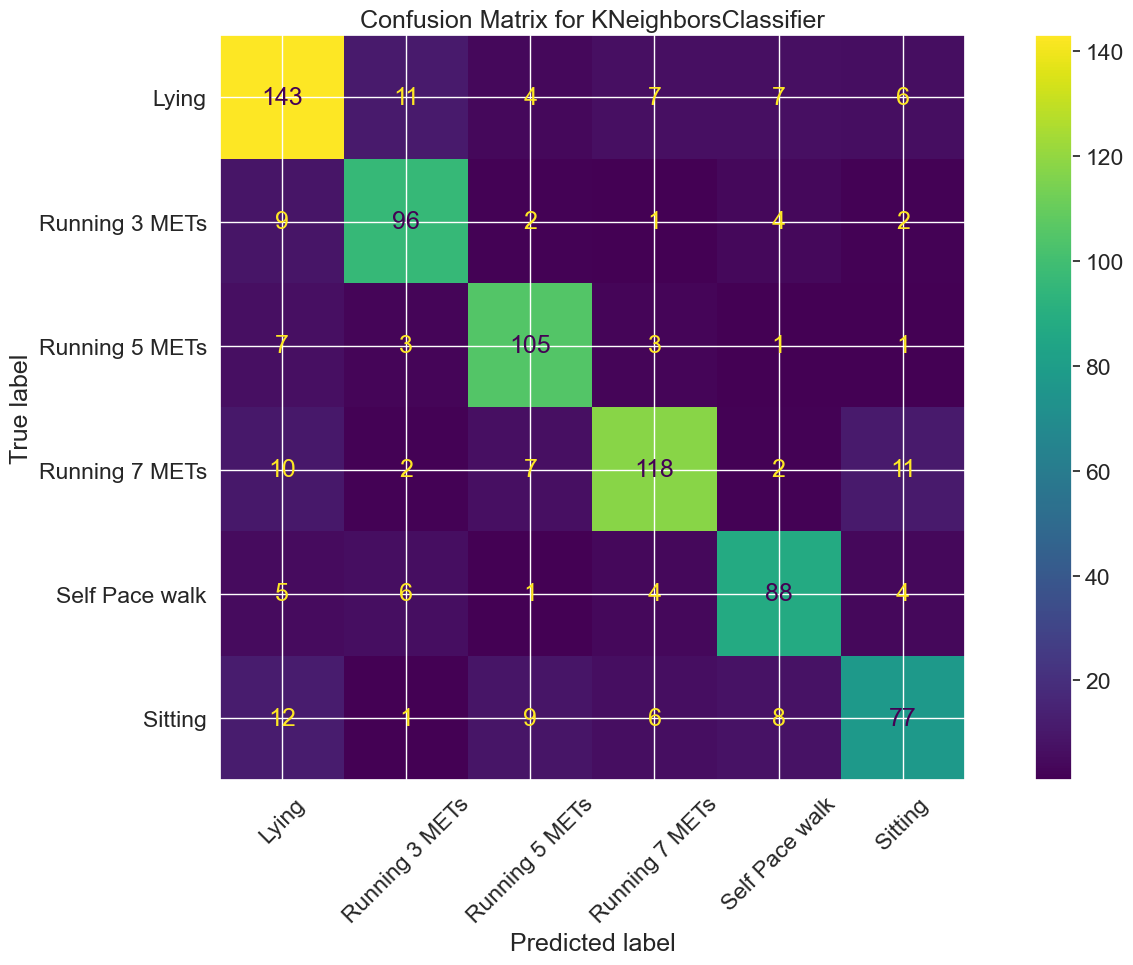

In [59]:
knn_model.display_confusion_matrix(1.5, (15,10))

Overall Performance: The diagonal elements show the number of correct predictions for each class. A higher value on the diagonal indicates better performance for that class.

Class-wise Performance:

Lying: The model seems to be quite accurate in identifying lying instances. However, it misclassifies some instances as "Running 3 METS."
Running 3 METS: The model performs well for this class, with most instances being correctly classified.
Running 5 METS: The model also performs well for this class, with some misclassifications into "Running 7 METS."
Running 7 METS: Similar to the previous class, the model performs well with some misclassifications into "Running 5 METS" and "Self Pace walk."
Self Pace walk: The model has a good performance for this class, with some misclassifications into "Running 7 METS."
Sitting: The model is quite accurate in identifying sitting instances, with a few misclassifications into "Lying."
Error Analysis: The off-diagonal elements reveal the types of errors the model makes. For example, the model often confuses "Running 5 METS" with "Running 7 METS."

 <font size="5"> Naive Bayes Pipeline Fitbit</font> 

In [60]:
parameters = {'clf__var_smoothing':[.1,.15,0.5]}
steps = [('scale',StandardScaler())]
nb_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,GaussianNB())
nb_model.create_pipeline(steps = steps)
grid_cv = nb_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

In [61]:
nb_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.48      0.62      0.54       178
Running 3 METs       0.28      0.72      0.40       114
Running 5 METs       0.42      0.18      0.26       120
Running 7 METs       0.39      0.18      0.25       150
Self Pace walk       0.28      0.10      0.15       108
       Sitting       0.12      0.10      0.11       113

      accuracy                           0.34       783
     macro avg       0.33      0.32      0.28       783
  weighted avg       0.34      0.34      0.30       783



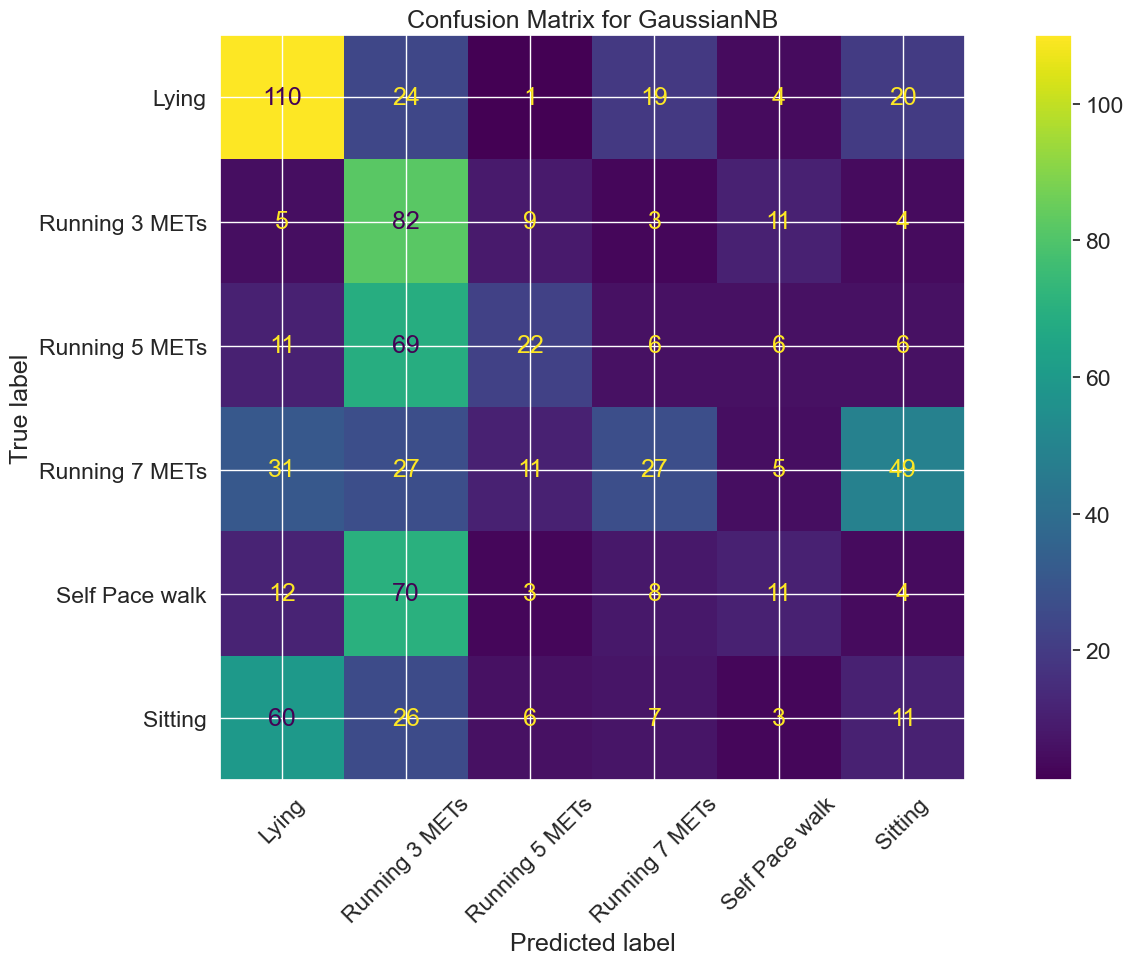

In [62]:
nb_model.display_confusion_matrix(1.5, (15,10))

Overall Performance:
The diagonal elements represent the number of instances that were correctly classified. A higher proportion of correct classifications on the diagonal indicates better performance.
The off-diagonal elements represent the number of instances that were misclassified.

Class-Wise Performance:
The confusion matrix can be used to evaluate the model's performance on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis:
The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

 <font size="5"> Gradient Boost Pipeline Fitbit</font> 

In [63]:
parameters = {'clf__n_estimators':[200,250] , 'clf__learning_rate':[0.5,0.1],'clf__max_features':["sqrt"], 'clf__max_depth':[10,5]}
g_boost_clf = GradientBoostingClassifier()
g_boost_model = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,g_boost_clf)
g_boost_model.create_pipeline()
grid_cv = g_boost_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [64]:
g_boost_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.83      0.88      0.85       178
Running 3 METs       0.92      0.95      0.93       114
Running 5 METs       0.90      0.93      0.91       120
Running 7 METs       0.98      0.96      0.97       150
Self Pace walk       0.92      0.83      0.87       108
       Sitting       0.85      0.83      0.84       113

      accuracy                           0.90       783
     macro avg       0.90      0.90      0.90       783
  weighted avg       0.90      0.90      0.90       783



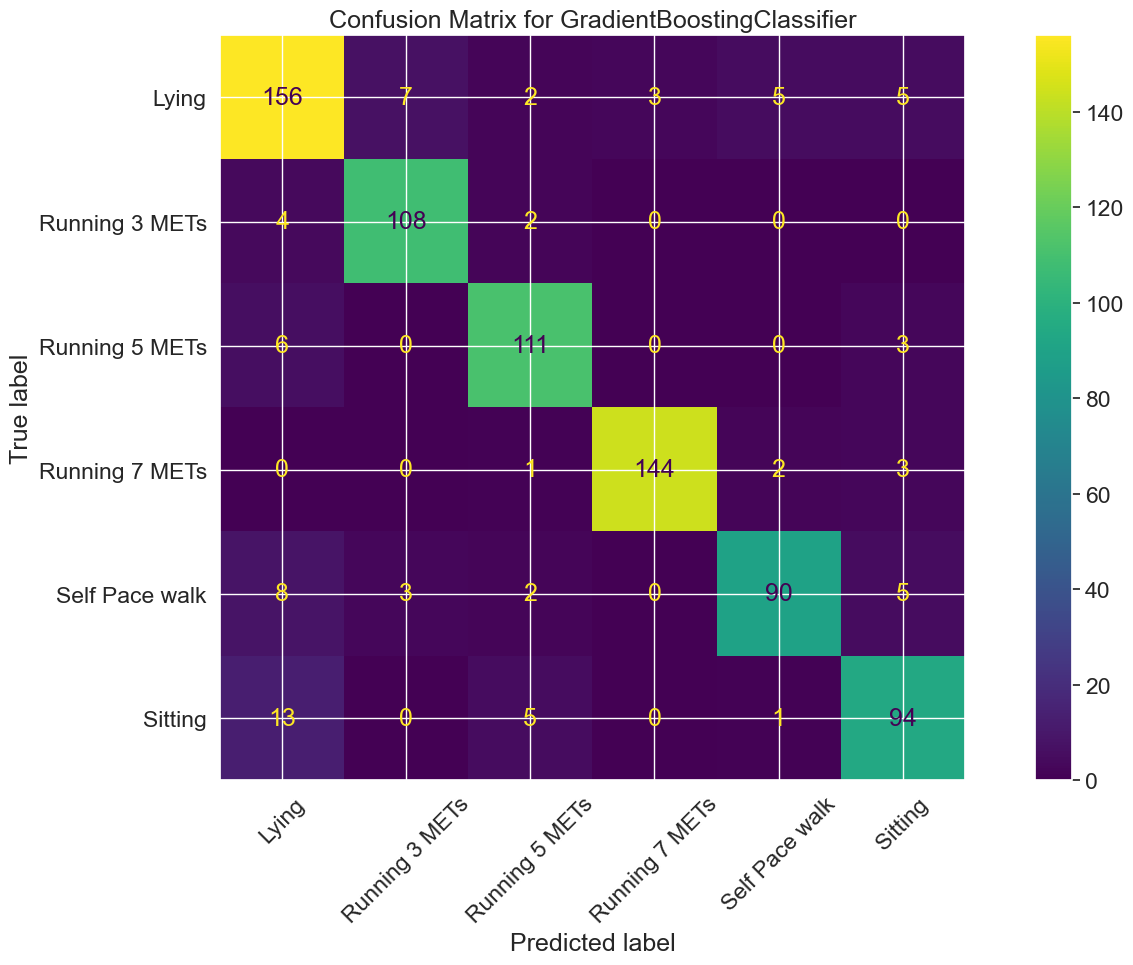

In [65]:
g_boost_model.display_confusion_matrix(1.5,(15,10))

Overall Performance:

The diagonal elements represent the number of instances that were correctly classified. A higher proportion of correct classifications on the diagonal indicates better performance.
The off-diagonal elements represent the number of instances that were misclassified.

Class-Wise Performance:
The confusion matrix can be used to evaluate the model's performance on each class separately. For example, we can see that the model performs well on the "Running 7 METS" class, with a high number of correct classifications. However, it struggles with the "Running 3 METS" class, with a significant number of misclassifications.

Error Analysis:
The confusion matrix can help identify the types of errors made by the model. For example, we can see that the model often misclassifies "Lying" as "Running 3 METS" and vice versa. This suggests that the model might be struggling to distinguish between these two classes.

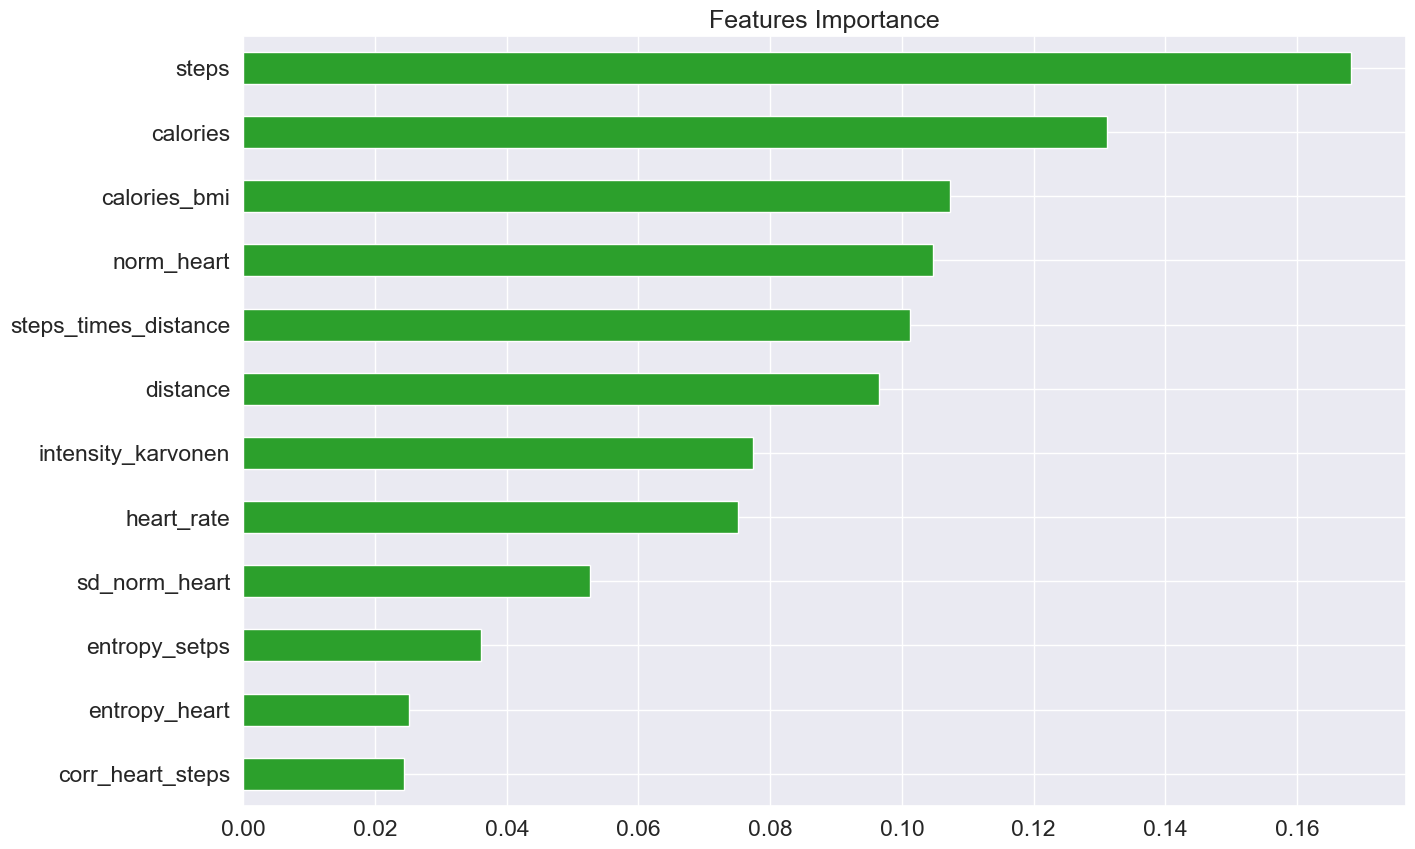

In [66]:
grid_cv.best_params_
gb_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
gb = RandomForestClassifier()
gb.set_params(**rf_params)
gb.fit(X_train,y_train)

importances = pd.Series(data=gb.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

Top Features:

steps and calories are the most influential features. This suggests that these features are crucial for accurate activity recognition.
calories_bmi, norm_heart, and steps_times_distance are also important features, indicating that BMI, heart rate, and the combined effect of steps and distance contribute significantly to the model's predictions.
Feature Ranking:

The features are ranked in descending order of importance. This ranking provides a clear understanding of the relative contribution of each feature.

The Gradient Boost again seems to perform the best on the Fitbit data with a 90% accuracy and high precision and recall on the Running 7 Mets Category. Again, the feature importance shows steps and calories to be the most important which is not what we saw with the Apple Watch data.

 <font size="5"> Final Thoughts</font> 

The EDA showed a lot of noise in many of the variables in the predictor space

Interestingly, the ensemble models Random Forest and Gradient Boosting performed well on accurately predicting the activity in the validation data set. On both the Fitbit and Apple Watch data the best performance was from the Gradient Boost model with around 90 and 84 percent accuracy respectively. The plus side of using the Stochastic Gradient Boost (when each weak classifier is limited in the predictors it can choose) is that we get to look at the variable importance feature. This also true of the Random Forest model.

We saw that the feature importance varied between the data collected on Apple Watch and Fitbit. It seems the ensemble models preferred the steps and calories on the Fitbit data and the heart rate related variables on the Apple Watch data. 

It would be interesting to see how these models would fair if the same data was collected using more current versions of these devices.
 
